# DL 2025 Time Series Transformers Project

In [ ]:
import os
import pandas as pd
import numpy as np
import openpyxl
import warnings
import joblib
warnings.filterwarnings('ignore')

## N-BEATS Resutls Reprted In The Article 
https://link.springer.com/article/10.1007/s10661-024-13164-2/tables/2


In [121]:
data = {
    "Region": ["A"] * 5 + ["B"] * 5,
    "Pollutant": ["NO", "NO2", "NOx", "O3", "PM2.5"] * 2,
    "Baseline N-BEATS model RRMSE": [0.69, 0.48, 0.44, 0.35, 0.34, 0.48, 0.42, 0.39, 0.12, 0.66],
    "syN-BEATS Predefined RRMSE": [0.31, 0.38, 0.32, 0.24, 0.22, 0.19, 0.37, 0.30, 0.07, 0.44],
    "syN-BEATS Predefined Reduction": ["55%", "21%", "27%", "31%", "35%", "60%", "12%", "23%", "42%", "33%"],
    "syN-BEATS Optimized RRMSE": [0.31, 0.16, 0.15, 0.06, 0.20, 0.17, 0.29, 0.21, 0.04, 0.21],
    "syN-BEATS Optimized Reduction": ["55%", "66%", "65%", "83%", "41%", "65%", "31%", "46%", "67%", "68%"]
}

df_nbeats = pd.DataFrame(data)
df_nbeats.to_csv('nbeats_results.csv')
df_nbeats

,Region,Pollutant,Baseline N-BEATS model RRMSE,syN-BEATS Predefined RRMSE,syN-BEATS Predefined Reduction,syN-BEATS Optimized RRMSE,syN-BEATS Optimized Reduction
0,A,NO,0.69,0.31,55%,0.31,55%
1,A,NO2,0.48,0.38,21%,0.16,66%
2,A,NOx,0.44,0.32,27%,0.15,65%
3,A,O3,0.35,0.24,31%,0.06,83%
4,A,PM2.5,0.34,0.22,35%,0.20,41%
5,B,NO,0.48,0.19,60%,0.17,65%
6,B,NO2,0.42,0.37,12%,0.29,31%
7,B,NOx,0.39,0.30,23%,0.21,46%
8,B,O3,0.12,0.07,42%,0.04,67%
9,B,PM2.5,0.66,0.44,33%,0.21,68%


##  Data Import and Processing — Following the Method Described in
https://github.com/josefberman/syN-BEATS/blob/main/main.py

In [ ]:
# Define the path to the data folder
data_folder = 'syN-BEATS/Data'

# Iterate over all files in the folder
for filename in os.listdir(data_folder):
    full_path = os.path.join(data_folder, filename)
    
    # Check if the file is an Excel or CSV
    if filename.endswith('.xlsx'):
        df = pd.read_excel(full_path)
    elif filename.endswith('.csv'):
        df = pd.read_csv(full_path)
    else:
        continue  # Skip unsupported file types

    # Create a variable name without file extension
    var_name = filename.rsplit('.', 1)[0]

    # Save as a global variable
    globals()[var_name] = df

    # Print message
    print(f"Loaded: {var_name}")

In [ ]:
met_coast_df = pd.concat([IMS_data_timorim_2020,IMS_data_timorim_2021,IMS_data_timorim_2022])
met_south_df = pd.concat([IMS_data_yotveta_2020,IMS_data_yotveta_2021,IMS_data_yotveta_2022])
aq_coast_df = AQ_data_timorim
aq_south_df = AQ_data_yotveta

TIME_LAG_MET_POLL = 3  # hours

# Timorim
met_coast_df['Datetime'] = pd.to_datetime(met_coast_df['Datetime'], format='%d/%m/%Y %H:%M')
met_coast_df['Datetime'] = met_coast_df['Datetime'] + pd.Timedelta(hours=TIME_LAG_MET_POLL)
met_coast_df.set_index('Datetime', drop=True, inplace=True)
met_coast_df.replace(to_replace='-', value=np.nan, inplace=True)
met_coast_df.interpolate(method='akima', inplace=True)
aq_coast_df[['time', 'date']] = aq_coast_df['Datetime'].str.split(expand=True)
aq_coast_df['Datetime'] = (pd.to_datetime(aq_coast_df.pop('date'), format='%d/%m/%Y') +
                           pd.to_timedelta(aq_coast_df.pop('time') + ':00'))
aq_coast_df['Datetime'] = pd.to_datetime(aq_coast_df['Datetime'], format='%d/%m/%Y %H:%M')
aq_coast_df.set_index('Datetime', drop=True, inplace=True)
aq_coast_df.replace(to_replace=0, value=np.nan, inplace=True)
aq_coast_df.interpolate(method='akima', inplace=True)
coast_df = met_coast_df.merge(aq_coast_df, how='inner', left_index=True, right_index=True)
coast_df = coast_df[coast_df['PM2.5 [ug/m^3]'] < 1000]
coast_df = coast_df[coast_df['PM2.5 [ug/m^3]'] > 0]
for col in coast_df.columns:
    coast_df[col] = pd.to_numeric(coast_df[col], errors='coerce')
coast_df.dropna(inplace=True, how='any')

# Yotveta
met_south_df['Datetime'] = pd.to_datetime(met_south_df['Datetime'], format='%d/%m/%Y %H:%M')
met_south_df['Datetime'] = met_south_df['Datetime'] + pd.Timedelta(hours=TIME_LAG_MET_POLL)
met_south_df.set_index('Datetime', drop=True, inplace=True)
met_south_df.replace(to_replace='-', value=np.nan, inplace=True)
met_south_df.interpolate(method='akima', inplace=True)
aq_south_df[['time', 'date']] = aq_south_df['Datetime'].str.split(expand=True)
aq_south_df['Datetime'] = (pd.to_datetime(aq_south_df.pop('date'), format='%d/%m/%Y') + pd.to_timedelta(
    aq_south_df.pop('time') + ':00'))
aq_south_df['Datetime'] = pd.to_datetime(aq_south_df['Datetime'], format='%d/%m/%Y %H:%M')
aq_south_df.set_index('Datetime', drop=True, inplace=True)
aq_south_df.replace(to_replace=0, value=np.nan, inplace=True)
aq_south_df.interpolate(method='akima', inplace=True)
south_df = met_south_df.merge(aq_south_df, how='inner', left_index=True, right_index=True)
for col in south_df.columns:
    south_df[col] = pd.to_numeric(south_df[col], errors='coerce')
south_df.dropna(inplace=True, how='any')

In [ ]:
display(coast_df.head(2))
display(south_df.head(2))

In [240]:
# south_df=south_df.to_excel('south_df.xlsx')
# coast_df=coast_df.to_excel('coast_df.xlsx')

# Informer Multivariate Target
https://github.com/MAZiqing/FEDformer/blob/master/models/Informer.py

## Area 1 - coast_df With Grid Search

In [ ]:
# === Informer Forecast with Grid Search, Early Stopping & RRMSE Summary ===
import pandas as pd
import numpy as np
import os, time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from models.informer import Model as Informer
from datetime import timedelta
from itertools import product

# ========== Fixed Parameters ==========
class BaseConfig:
    pred_len = 24
    seq_len = 120
    label_len = 12
    enc_in = 16
    dec_in = 15
    c_out = 5
    embed = 'timeF'
    freq = 'h'

# ========== Grid Search Parameter Sets ==========
grid_param_sets = [
    {
        'd_model': [64, 128],
        'n_heads': [4],
        'e_layers': [2],
        'd_layers': [1],
        'd_ff': [128],
        'dropout': [0.1],
        'activation': ['gelu'],
        'output_attention': [False],
        'distil': [True],
        'factor': [5],
        'lr': [1e-3, 5e-4]
    },
    {
        'd_model': [128],
        'n_heads': [8],
        'e_layers': [3],
        'd_layers': [2],
        'd_ff': [256],
        'dropout': [0.3],
        'activation': ['gelu'],
        'output_attention': [False],
        'distil': [True],
        'factor': [5],
        'lr': [1e-4]
    }
]

# ========== Paths & Parameters ==========
INPUT_LEN = BaseConfig.seq_len
OUTPUT_LEN = BaseConfig.pred_len
NUM_DAYS = 7
TARGET_COLS = ['NO [ug/m^3]', 'NO2 [ug/m^3]', 'NOX [ug/m^3]', 'O3 [ug/m^3]', 'PM2.5 [ug/m^3]']
DATA_PATH = "coast_df.xlsx"
SAVE_DIR = "grid_results"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(SAVE_DIR, exist_ok=True)

# ========== Load & Preprocess Data Once ==========
df = pd.read_excel(DATA_PATH)
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime").sort_index()
df = df.resample("H").asfreq().interpolate().dropna()

target_indices = [df.columns.get_loc(col) for col in TARGET_COLS]
dec_input_indices = [i for i in range(df.shape[1]) if i not in target_indices]

split_point = pd.to_datetime("2022-06-01 00:00:00")
split_idx = df.index.get_loc(split_point)
df_train_full = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

val_cut_idx = int(len(df_train_full) * 0.8)
df_train = df_train_full.iloc[:val_cut_idx]
df_val = df_train_full.iloc[val_cut_idx:]

scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = pd.DataFrame(scaler.transform(df_train), columns=df.columns, index=df_train.index)
scaled_val = pd.DataFrame(scaler.transform(df_val), columns=df.columns, index=df_val.index)
scaled_test = pd.DataFrame(scaler.transform(df_test), columns=df.columns, index=df_test.index)
scaled_df = pd.concat([scaled_train, scaled_val, scaled_test])

arr = scaled_df.values
X, y = [], []
for i in range(len(arr) - INPUT_LEN - OUTPUT_LEN):
    x_seq = arr[i:i + INPUT_LEN]
    y_seq = arr[i + INPUT_LEN:i + INPUT_LEN + OUTPUT_LEN, target_indices]
    X.append(x_seq)
    y.append(y_seq)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

val_size = int(len(X) * 0.2)
X_val, y_val = X[-val_size:], y[-val_size:]
X_train, y_train = X[:-val_size], y[:-val_size]
test_start_index = len(scaled_train) + len(scaled_val) - INPUT_LEN - OUTPUT_LEN
X_test, y_test = X[test_start_index:], y[test_start_index:]

class WindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# ========== Run Grid Search ==========
results = []
run_id = 0

for grid_params in grid_param_sets:
    param_grid = list(product(*grid_params.values()))
    param_names = list(grid_params.keys())

    for param_values in param_grid:
        cfg = BaseConfig()
        for name, value in zip(param_names, param_values):
            setattr(cfg, name, value)

        model_dir = os.path.join(SAVE_DIR, f"run_{run_id}")
        os.makedirs(model_dir, exist_ok=True)

        cfg.enc_in = X.shape[2]
        cfg.dec_in = X.shape[2] - len(target_indices)
        cfg.c_out = len(TARGET_COLS)

        train_loader = DataLoader(WindowDataset(X_train, y_train), batch_size=32, shuffle=True)
        val_loader = DataLoader(WindowDataset(X_val, y_val), batch_size=32)

        model = Informer(cfg).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=getattr(cfg, 'lr', 1e-3))
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        early_stop_counter = 0
        patience = 8
        best_model_path = os.path.join(model_dir, "best_model.pth")
        train_loss_hist, val_loss_hist = [], []

        start_time = time.time()

        for epoch in range(50):
            model.train()
            train_losses = []
            for xb, yb in train_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                x_enc = xb
                x_dec = xb[:, -cfg.label_len:, dec_input_indices]
                x_dec = torch.cat([x_dec, torch.zeros((xb.size(0), OUTPUT_LEN - cfg.label_len, cfg.dec_in)).to(DEVICE)], dim=1)
                preds = model(x_enc, torch.zeros((xb.size(0), INPUT_LEN, 4)).to(DEVICE), x_dec, torch.zeros((xb.size(0), OUTPUT_LEN, 4)).to(DEVICE))
                loss = criterion(preds, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    x_enc = xb
                    x_dec = xb[:, -cfg.label_len:, dec_input_indices]
                    x_dec = torch.cat([x_dec, torch.zeros((xb.size(0), OUTPUT_LEN - cfg.label_len, cfg.dec_in)).to(DEVICE)], dim=1)
                    preds = model(x_enc, torch.zeros((xb.size(0), INPUT_LEN, 4)).to(DEVICE), x_dec, torch.zeros((xb.size(0), OUTPUT_LEN, 4)).to(DEVICE))
                    val_loss = criterion(preds, yb)
                    val_losses.append(val_loss.item())

            avg_val = np.mean(val_losses)
            train_loss_hist.append(np.mean(train_losses))
            val_loss_hist.append(avg_val)

            if avg_val < best_val_loss:
                best_val_loss = avg_val
                torch.save(model.state_dict(), best_model_path)
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    break

        model.load_state_dict(torch.load(best_model_path))
        model.eval()

        def inverse_transform_prediction(pred_scaled):
            batch_size, output_len, num_targets = pred_scaled.shape
            dummy = np.zeros((batch_size * output_len, df.shape[1]))
            for i, col_idx in enumerate(target_indices):
                dummy[:, col_idx] = pred_scaled[:, :, i].reshape(-1)
            inversed = scaler.inverse_transform(dummy)
            results = np.stack([inversed[:, idx].reshape(batch_size, output_len) for idx in target_indices], axis=-1)
            return results

        def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred) ** 2))
        def rrmse(y_true, y_pred): return rmse(y_true, y_pred) / (np.mean(y_true) + 1e-8)

        all_rrmses_per_target = {col: [] for col in TARGET_COLS}

        with torch.no_grad():
            for day in range(NUM_DAYS):
                input_tensor = torch.tensor(X_test[day:day+1], dtype=torch.float32).to(DEVICE)
                x_dec = input_tensor[:, -cfg.label_len:, dec_input_indices]
                x_dec = torch.cat([x_dec, torch.zeros((1, OUTPUT_LEN - cfg.label_len, cfg.dec_in)).to(DEVICE)], dim=1)

                pred = model(input_tensor,
                             torch.zeros((1, INPUT_LEN, 4)).to(DEVICE),
                             x_dec,
                             torch.zeros((1, OUTPUT_LEN, 4)).to(DEVICE)).cpu().numpy()

                pred_orig = inverse_transform_prediction(pred)
                y_true_orig = inverse_transform_prediction(y_test[day:day+1])

                for j, col in enumerate(TARGET_COLS):
                    daily_rrmse = rrmse(y_true_orig[0, :, j], pred_orig[0, :, j])
                    all_rrmses_per_target[col].append(daily_rrmse)

        elapsed = time.time() - start_time

        rrmse_avg = {col: np.mean(vals) for col, vals in all_rrmses_per_target.items()}
        overall_avg = np.mean(list(rrmse_avg.values()))
        result = {"run_id": run_id, **dict(zip(param_names, param_values)), **rrmse_avg, "overall_rrmse": overall_avg, "runtime_sec": elapsed}
        results.append(result)
        pd.DataFrame([result]).to_csv(os.path.join(model_dir, "result_summary.csv"), index=False)
        run_id += 1

# ========== Save All Results ==========
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(SAVE_DIR, "grid_search_results.csv"), index=False)
print("\nAll grid search results saved to grid_search_results.csv")

## coast_df with Optimal Configuration 

In [ ]:
# === Informer Forecast with Grid Search, Early Stopping & RRMSE Summary ===
import pandas as pd
import numpy as np
import os, time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from models.informer import Model as Informer
from datetime import timedelta
from itertools import product

# ========== Fixed Parameters ==========
class BaseConfig:
    pred_len = 24
    seq_len = 120
    label_len = 12
    enc_in = 16
    dec_in = 15
    c_out = 5
    embed = 'timeF'
    freq = 'h'

# ========== Grid Search Parameter Sets ==========
grid_param_sets = [
    {
        'd_model': [128],
        'n_heads': [8],
        'e_layers': [3],
        'd_layers': [2],
        'd_ff': [256],
        'dropout': [0.3],
        'activation': ['gelu'],
        'output_attention': [False],
        'distil': [True],
        'factor': [5],
        'lr': [1e-4]
    }
]

# ========== Paths & Parameters ==========
INPUT_LEN = BaseConfig.seq_len
OUTPUT_LEN = BaseConfig.pred_len
NUM_DAYS = 7
TARGET_COLS = ['NO [ug/m^3]', 'NO2 [ug/m^3]', 'NOX [ug/m^3]', 'O3 [ug/m^3]', 'PM2.5 [ug/m^3]']
DATA_PATH = "coast_df.xlsx"
SAVE_DIR = "grid_results"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(SAVE_DIR, exist_ok=True)

# ========== Load & Preprocess Data Once ==========
df = pd.read_excel(DATA_PATH)
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime").sort_index()
df = df.resample("H").asfreq().interpolate().dropna()

target_indices = [df.columns.get_loc(col) for col in TARGET_COLS]
dec_input_indices = [i for i in range(df.shape[1]) if i not in target_indices]

split_point = pd.to_datetime("2022-06-01 00:00:00")
split_idx = df.index.get_loc(split_point)
df_train_full = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

val_cut_idx = int(len(df_train_full) * 0.8)
df_train = df_train_full.iloc[:val_cut_idx]
df_val = df_train_full.iloc[val_cut_idx:]

scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = pd.DataFrame(scaler.transform(df_train), columns=df.columns, index=df_train.index)
scaled_val = pd.DataFrame(scaler.transform(df_val), columns=df.columns, index=df_val.index)
scaled_test = pd.DataFrame(scaler.transform(df_test), columns=df.columns, index=df_test.index)
scaled_df = pd.concat([scaled_train, scaled_val, scaled_test])

arr = scaled_df.values
X, y = [], []
for i in range(len(arr) - INPUT_LEN - OUTPUT_LEN):
    x_seq = arr[i:i + INPUT_LEN]
    y_seq = arr[i + INPUT_LEN:i + INPUT_LEN + OUTPUT_LEN, target_indices]
    X.append(x_seq)
    y.append(y_seq)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

val_size = int(len(X) * 0.2)
X_val, y_val = X[-val_size:], y[-val_size:]
X_train, y_train = X[:-val_size], y[:-val_size]
test_start_index = len(scaled_train) + len(scaled_val) - INPUT_LEN - OUTPUT_LEN
X_test, y_test = X[test_start_index:], y[test_start_index:]

class WindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# ========== Run Grid Search ==========
results = []
run_id = 0

for grid_params in grid_param_sets:
    param_grid = list(product(*grid_params.values()))
    param_names = list(grid_params.keys())

    for param_values in param_grid:
        cfg = BaseConfig()
        for name, value in zip(param_names, param_values):
            setattr(cfg, name, value)

        model_dir = os.path.join(SAVE_DIR, f"run_{run_id}")
        os.makedirs(model_dir, exist_ok=True)

        cfg.enc_in = X.shape[2]
        cfg.dec_in = X.shape[2] - len(target_indices)
        cfg.c_out = len(TARGET_COLS)

        train_loader = DataLoader(WindowDataset(X_train, y_train), batch_size=32, shuffle=True)
        val_loader = DataLoader(WindowDataset(X_val, y_val), batch_size=32)

        model = Informer(cfg).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=getattr(cfg, 'lr', 1e-3))
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        early_stop_counter = 0
        patience = 8
        best_model_path = os.path.join(model_dir, "best_model.pth")
        train_loss_hist, val_loss_hist = [], []

        start_time = time.time()

        for epoch in range(50):
            model.train()
            train_losses = []
            for xb, yb in train_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                x_enc = xb
                x_dec = xb[:, -cfg.label_len:, dec_input_indices]
                x_dec = torch.cat([x_dec, torch.zeros((xb.size(0), OUTPUT_LEN - cfg.label_len, cfg.dec_in)).to(DEVICE)], dim=1)
                preds = model(x_enc, torch.zeros((xb.size(0), INPUT_LEN, 4)).to(DEVICE), x_dec, torch.zeros((xb.size(0), OUTPUT_LEN, 4)).to(DEVICE))
                loss = criterion(preds, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    x_enc = xb
                    x_dec = xb[:, -cfg.label_len:, dec_input_indices]
                    x_dec = torch.cat([x_dec, torch.zeros((xb.size(0), OUTPUT_LEN - cfg.label_len, cfg.dec_in)).to(DEVICE)], dim=1)
                    preds = model(x_enc, torch.zeros((xb.size(0), INPUT_LEN, 4)).to(DEVICE), x_dec, torch.zeros((xb.size(0), OUTPUT_LEN, 4)).to(DEVICE))
                    val_loss = criterion(preds, yb)
                    val_losses.append(val_loss.item())

            avg_val = np.mean(val_losses)
            train_loss_hist.append(np.mean(train_losses))
            val_loss_hist.append(avg_val)

            if avg_val < best_val_loss:
                best_val_loss = avg_val
                torch.save(model.state_dict(), best_model_path)
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    break

        model.load_state_dict(torch.load(best_model_path))
        model.eval()

        def inverse_transform_prediction(pred_scaled):
            batch_size, output_len, num_targets = pred_scaled.shape
            dummy = np.zeros((batch_size * output_len, df.shape[1]))
            for i, col_idx in enumerate(target_indices):
                dummy[:, col_idx] = pred_scaled[:, :, i].reshape(-1)
            inversed = scaler.inverse_transform(dummy)
            results = np.stack([inversed[:, idx].reshape(batch_size, output_len) for idx in target_indices], axis=-1)
            return results

        def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred) ** 2))
        def rrmse(y_true, y_pred): return rmse(y_true, y_pred) / (np.mean(y_true) + 1e-8)

        all_rrmses_per_target = {col: [] for col in TARGET_COLS}

        with torch.no_grad():
            test_day_starts = [i * 24 for i in range(NUM_DAYS)]
            test_start_datetime = df_test.index[0] + timedelta(hours=INPUT_LEN)

            for i, idx in enumerate(test_day_starts):
                if idx >= len(X_test):
                    print(f"Skipped day {i+1} – not enough test data at index {idx}")
                    continue

                input_tensor = torch.tensor(X_test[idx:idx+1], dtype=torch.float32).to(DEVICE)
                x_dec = input_tensor[:, -cfg.label_len:, dec_input_indices]
                x_dec = torch.cat([
                    x_dec,
                    torch.zeros((1, OUTPUT_LEN - cfg.label_len, cfg.dec_in)).to(DEVICE)
                ], dim=1)

                pred = model(
                    input_tensor,
                    torch.zeros((1, INPUT_LEN, 4)).to(DEVICE),
                    x_dec,
                    torch.zeros((1, OUTPUT_LEN, 4)).to(DEVICE)
                ).cpu().numpy()

                pred_orig = inverse_transform_prediction(pred)
                y_true_orig = inverse_transform_prediction(y_test[idx:idx+1])

                start_dt = test_start_datetime + timedelta(hours=idx)
                date_range = pd.date_range(start=start_dt, periods=OUTPUT_LEN, freq="H")

                for j, col in enumerate(TARGET_COLS):
                    daily_rrmse = rrmse(y_true_orig[0, :, j], pred_orig[0, :, j])
                    all_rrmses_per_target[col].append(daily_rrmse)

                    comparison = pd.DataFrame({
                        "datetime": date_range,
                        "truth": y_true_orig[0, :, j],
                        "prediction": pred_orig[0, :, j]
                    })

                    fname = f"day{i+1}_{col.replace('/', '').replace(' ', '_')}.csv"
                    comparison.to_csv(os.path.join(model_dir, fname), index=False)

        elapsed = time.time() - start_time

        rrmse_avg = {col: np.mean(vals) for col, vals in all_rrmses_per_target.items()}
        overall_avg = np.mean(list(rrmse_avg.values()))
        result = {"run_id": run_id, **dict(zip(param_names, param_values)), **rrmse_avg, "overall_rrmse": overall_avg, "runtime_sec": elapsed}
        results.append(result)
        pd.DataFrame([result]).to_csv(os.path.join(model_dir, "result_summary.csv"), index=False)
        run_id += 1

# ========== Save All Results ==========
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(SAVE_DIR, "grid_search_results.csv"), index=False)
print("\nAll grid search results saved to grid_search_results.csv")

## south_df With Optimal Configuration

In [ ]:
# === Informer Forecast with Grid Search, Early Stopping & RRMSE Summary ===

import pandas as pd
import numpy as np
import os, time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from models.informer import Model as Informer
from datetime import timedelta
from itertools import product

# ========== Fixed Parameters ==========
class BaseConfig:
    pred_len = 24
    seq_len = 120
    label_len = 12
    enc_in = 16
    dec_in = 15
    c_out = 5
    embed = 'timeF'
    freq = 'h'

# ========== Grid Search Parameter Sets ==========
grid_param_sets = [
    {
        'd_model': [128],
        'n_heads': [8],
        'e_layers': [3],
        'd_layers': [2],
        'd_ff': [256],
        'dropout': [0.3],
        'activation': ['gelu'],
        'output_attention': [False],
        'distil': [True],
        'factor': [5],
        'lr': [1e-4]
    }
]

# ========== Paths & Parameters ==========
INPUT_LEN_south = BaseConfig.seq_len
OUTPUT_LEN_south = BaseConfig.pred_len
NUM_DAYS_south = 7
TARGET_COLS_south = ['NO [ug/m^3]', 'NO2 [ug/m^3]', 'NOX [ug/m^3]', 'O3 [ug/m^3]', 'PM2.5 [ug/m^3]']
DATA_PATH_south = "south_df.xlsx"
SAVE_DIR_south = "grid_results"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(SAVE_DIR_south, exist_ok=True)

# ========== Load & Preprocess Data Once ==========
df_south = pd.read_excel(DATA_PATH_south)
df_south["Datetime"] = pd.to_datetime(df_south["Datetime"])
df_south = df_south.set_index("Datetime").sort_index()
df_south = df_south.resample("H").asfreq().interpolate().dropna()

target_indices_south = [df_south.columns.get_loc(col) for col in TARGET_COLS_south]
dec_input_indices_south = [i for i in range(df_south.shape[1]) if i not in target_indices_south]

split_point = pd.to_datetime("2022-06-01 00:00:00")
split_idx = df_south.index.get_loc(split_point)
df_train_full = df_south.iloc[:split_idx]
df_test = df_south.iloc[split_idx:]

val_cut_idx = int(len(df_train_full) * 0.8)
df_train = df_train_full.iloc[:val_cut_idx]
df_val = df_train_full.iloc[val_cut_idx:]

scaler_south = MinMaxScaler()
scaler_south.fit(df_train)
scaled_train = pd.DataFrame(scaler_south.transform(df_train), columns=df_south.columns, index=df_train.index)
scaled_val = pd.DataFrame(scaler_south.transform(df_val), columns=df_south.columns, index=df_val.index)
scaled_test = pd.DataFrame(scaler_south.transform(df_test), columns=df_south.columns, index=df_test.index)
scaled_df = pd.concat([scaled_train, scaled_val, scaled_test])

arr = scaled_df.values
X_south, y_south = [], []
for i in range(len(arr) - INPUT_LEN_south - OUTPUT_LEN_south):
    x_seq = arr[i:i + INPUT_LEN_south]
    y_seq = arr[i + INPUT_LEN_south:i + INPUT_LEN_south + OUTPUT_LEN_south, target_indices_south]
    X_south.append(x_seq)
    y_south.append(y_seq)
X_south = np.array(X_south, dtype=np.float32)
y_south = np.array(y_south, dtype=np.float32)

val_size = int(len(X_south) * 0.2)
X_val, y_val = X_south[-val_size:], y_south[-val_size:]
X_train, y_train = X_south[:-val_size], y_south[:-val_size]
test_start_index = len(scaled_train) + len(scaled_val) - INPUT_LEN_south - OUTPUT_LEN_south
X_test, y_test = X_south[test_start_index:], y_south[test_start_index:]

class WindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# ========== Run Grid Search ==========
results_south = []
run_id = 0

for grid_params in grid_param_sets:
    param_grid = list(product(*grid_params.values()))
    param_names = list(grid_params.keys())

    for param_values in param_grid:
        cfg = BaseConfig()
        for name, value in zip(param_names, param_values):
            setattr(cfg, name, value)

        model_dir = os.path.join(SAVE_DIR_south, f"run_{run_id}_south")
        os.makedirs(model_dir, exist_ok=True)

        cfg.enc_in = X_south.shape[2]
        cfg.dec_in = X_south.shape[2] - len(target_indices_south)
        cfg.c_out = len(TARGET_COLS_south)

        train_loader = DataLoader(WindowDataset(X_train, y_train), batch_size=32, shuffle=True)
        val_loader = DataLoader(WindowDataset(X_val, y_val), batch_size=32)

        model = Informer(cfg).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=getattr(cfg, 'lr', 1e-3))
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        early_stop_counter = 0
        patience = 8
        best_model_path = os.path.join(model_dir, "best_model_south.pth")
        train_loss_hist, val_loss_hist = [], []

        start_time = time.time()

        for epoch in range(50):
            model.train()
            train_losses = []
            for xb, yb in train_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                x_enc = xb
                x_dec = xb[:, -cfg.label_len:, dec_input_indices_south]
                x_dec = torch.cat([x_dec, torch.zeros((xb.size(0), OUTPUT_LEN_south - cfg.label_len, cfg.dec_in)).to(DEVICE)], dim=1)
                preds = model(x_enc, torch.zeros((xb.size(0), INPUT_LEN_south, 4)).to(DEVICE), x_dec, torch.zeros((xb.size(0), OUTPUT_LEN_south, 4)).to(DEVICE))
                loss = criterion(preds, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    x_enc = xb
                    x_dec = xb[:, -cfg.label_len:, dec_input_indices_south]
                    x_dec = torch.cat([x_dec, torch.zeros((xb.size(0), OUTPUT_LEN_south - cfg.label_len, cfg.dec_in)).to(DEVICE)], dim=1)
                    preds = model(x_enc, torch.zeros((xb.size(0), INPUT_LEN_south, 4)).to(DEVICE), x_dec, torch.zeros((xb.size(0), OUTPUT_LEN_south, 4)).to(DEVICE))
                    val_loss = criterion(preds, yb)
                    val_losses.append(val_loss.item())

            avg_val = np.mean(val_losses)
            train_loss_hist.append(np.mean(train_losses))
            val_loss_hist.append(avg_val)

            if avg_val < best_val_loss:
                best_val_loss = avg_val
                torch.save(model.state_dict(), best_model_path)
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    break

        model.load_state_dict(torch.load(best_model_path))
        model.eval()

        def inverse_transform_prediction(pred_scaled):
            batch_size, output_len, num_targets = pred_scaled.shape
            dummy = np.zeros((batch_size * output_len, df_south.shape[1]))
            for i, col_idx in enumerate(target_indices_south):
                dummy[:, col_idx] = pred_scaled[:, :, i].reshape(-1)
            inversed = scaler_south.inverse_transform(dummy)
            results = np.stack([inversed[:, idx].reshape(batch_size, output_len) for idx in target_indices_south], axis=-1)
            return results

        def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred) ** 2))
        def rrmse(y_true, y_pred): return rmse(y_true, y_pred) / (np.mean(y_true) + 1e-8)

        all_rrmses_per_target = {col: [] for col in TARGET_COLS_south}

        with torch.no_grad():
            for day in range(NUM_DAYS_south):
                input_tensor = torch.tensor(X_test[day:day+1], dtype=torch.float32).to(DEVICE)
                x_dec = input_tensor[:, -cfg.label_len:, dec_input_indices_south]
                x_dec = torch.cat([x_dec, torch.zeros((1, OUTPUT_LEN_south - cfg.label_len, cfg.dec_in)).to(DEVICE)], dim=1)

                pred = model(input_tensor,
                             torch.zeros((1, INPUT_LEN_south, 4)).to(DEVICE),
                             x_dec,
                             torch.zeros((1, OUTPUT_LEN_south, 4)).to(DEVICE)).cpu().numpy()

                pred_orig = inverse_transform_prediction(pred)
                y_true_orig = inverse_transform_prediction(y_test[day:day+1])

                for j, col in enumerate(TARGET_COLS_south):
                    daily_rrmse = rrmse(y_true_orig[0, :, j], pred_orig[0, :, j])
                    all_rrmses_per_target[col].append(daily_rrmse)

                    pred_df = pd.DataFrame(pred_orig[0, :, j], columns=["prediction"])
                    true_df = pd.DataFrame(y_true_orig[0, :, j], columns=["truth"])
                    comparison = pd.concat([true_df, pred_df], axis=1)
                    comparison.to_csv(os.path.join(model_dir, f"day{day+1}_{col.replace('/', '').replace(' ', '_')}_south.csv"), index=False)

        elapsed = time.time() - start_time

        rrmse_avg = {col: np.mean(vals) for col, vals in all_rrmses_per_target.items()}
        overall_avg = np.mean(list(rrmse_avg.values()))
        result = {"run_id": run_id, **dict(zip(param_names, param_values)), **rrmse_avg, "overall_rrmse": overall_avg, "runtime_sec": elapsed}
        results_south.append(result)
        pd.DataFrame([result]).to_csv(os.path.join(model_dir, "result_summary_south.csv"), index=False)
        run_id += 1

# ========== Save All Results ==========
results_df = pd.DataFrame(results_south)
results_df.to_csv(os.path.join(SAVE_DIR_south, "grid_search_results_south.csv"), index=False)
print("\nAll grid search results saved to grid_search_results_south.csv")

# PatchTST  - Univairate Target (Loop for 5) 
https://github.com/yuqinie98/PatchTST/blob/main/PatchTST_supervised/models/PatchTST.py

## coast_df with Optimal Configuration 

In [ ]:
import os, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append('/Users/dorhalevy')  # גישה ל־models
from models.PatchTST import Model as PatchTSTModel

# === CONFIG ===
class BaseConfig:
    seq_len = 120
    pred_len = 24
    d_model = 64
    n_heads = 4
    e_layers = 2
    d_layers = 1
    d_ff = 128
    dropout = 0.1
    fc_dropout = 0.1
    head_dropout = 0.1
    individual = False
    patch_len = 12
    stride = 6
    padding_patch = "end"
    revin = True
    affine = True
    subtract_last = False
    decomposition = True
    kernel_size = 25

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "coast_df.xlsx"
SAVE_DIR = "patchtst_coast_results"
TARGET_COLS = ['NO [ug/m^3]', 'NO2 [ug/m^3]', 'NOX [ug/m^3]', 'O3 [ug/m^3]', 'PM2.5 [ug/m^3]']
os.makedirs(SAVE_DIR, exist_ok=True)

# === LOAD DATA ===
df_coast = pd.read_excel(DATA_PATH)
df_coast["Datetime"] = pd.to_datetime(df_coast["Datetime"])
df_coast = df_coast.set_index("Datetime").sort_index()
df_coast = df_coast.resample("H").asfreq().interpolate().dropna()

# === LOOP PER TARGET ===
results_coast = {}
total_start_time = time.time()

for target in TARGET_COLS:
    start_time = time.time()

    safe_target = target.replace('/', '').replace('[', '').replace(']', '').replace(' ', '_')
    target_dir_coast = os.path.join(SAVE_DIR, safe_target)
    os.makedirs(target_dir_coast, exist_ok=True)

    print(f"\n===== Processing target: {target} =====")
    config = BaseConfig()
    config.enc_in = df_coast.shape[1]
    config.c_out = 1

    target_idx = df_coast.columns.get_loc(target)
    df_train_full_coast = df_coast[df_coast.index < "2022-06-01"]
    df_test_coast = df_coast[df_coast.index >= "2022-06-01"]

    val_split = int(len(df_train_full_coast) * 0.8)
    df_train_coast = df_train_full_coast.iloc[:val_split]
    df_val_coast = df_train_full_coast.iloc[val_split:]

    scaler_coast = MinMaxScaler()
    scaler_coast.fit(df_train_coast)
    scaled_coast = scaler_coast.transform(pd.concat([df_train_coast, df_val_coast, df_test_coast]))

    X_coast, y_coast = [], []
    for i in range(len(scaled_coast) - config.seq_len - config.pred_len):
        x_seq = scaled_coast[i:i+config.seq_len]
        y_seq = scaled_coast[i+config.seq_len:i+config.seq_len+config.pred_len, target_idx]
        X_coast.append(x_seq)
        y_coast.append(y_seq)
    X_coast, y_coast = np.array(X_coast, dtype=np.float32), np.array(y_coast, dtype=np.float32)
    y_coast = y_coast[..., np.newaxis]

    val_size = len(df_val_coast) - config.seq_len - config.pred_len
    X_train_coast, y_train_coast = X_coast[:-val_size], y_coast[:-val_size]
    X_val_coast, y_val_coast = X_coast[-val_size:], y_coast[-val_size:]
    test_start_idx = len(df_train_full_coast) - config.seq_len - config.pred_len
    X_test_coast, y_test_coast = X_coast[test_start_idx:], y_coast[test_start_idx:]

    class WindowDatasetCoast(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)
        def __len__(self): return len(self.X)
        def __getitem__(self, idx): return self.X[idx], self.y[idx]

    train_loader_coast = DataLoader(WindowDatasetCoast(X_train_coast, y_train_coast), batch_size=32, shuffle=True)
    val_loader_coast = DataLoader(WindowDatasetCoast(X_val_coast, y_val_coast), batch_size=32)

    model_coast = PatchTSTModel(config).to(DEVICE)
    optimizer = torch.optim.Adam(model_coast.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()
    best_val_loss = float('inf')
    patience, patience_counter = 3, 0

    for epoch in range(10):
        model_coast.train()
        for xb, yb in train_loader_coast:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model_coast(xb, target_idx=target_idx)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model_coast.eval()
        val_loss = []
        with torch.no_grad():
            for xb, yb in val_loader_coast:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model_coast(xb, target_idx=target_idx)
                val_loss.append(loss_fn(pred, yb).item())
        val_avg = np.mean(val_loss)
        print(f"Epoch {epoch+1}: Val Loss = {val_avg:.4f}")

        if val_avg < best_val_loss:
            best_val_loss = val_avg
            torch.save(model_coast.state_dict(), os.path.join(target_dir_coast, "best_model.pth"))
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model_coast.load_state_dict(torch.load(os.path.join(target_dir_coast, "best_model.pth")))
    model_coast.eval()

    def inverse_transform_coast(pred_scaled):
        assert pred_scaled.shape[-1] == 1
        B, T, _ = pred_scaled.shape
        dummy = np.zeros((B * T, df_coast.shape[1]))
        dummy[:, target_idx] = pred_scaled.reshape(-1)
        inv = scaler_coast.inverse_transform(dummy)
        return inv[:, target_idx].reshape(B, T)

    rrmse_list_coast = []
    for day in range(7):
        x_input = torch.tensor(X_test_coast[day:day+1], dtype=torch.float32).to(DEVICE)
        with torch.no_grad():
            pred = model_coast(x_input, target_idx=target_idx).cpu().numpy()
        y_true = inverse_transform_coast(y_test_coast[day:day+1])
        y_pred = inverse_transform_coast(pred)

        err = np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.mean(y_true) + 1e-8)
        rrmse_list_coast.append(err)

        forecast_start = df_test_coast.index[day + config.seq_len]
        forecast_range = pd.date_range(start=forecast_start, periods=config.pred_len, freq="H")

        df_result = pd.DataFrame({
            "Datetime": forecast_range,
            "truth": y_true.flatten(),
            "prediction": y_pred.flatten()
        })
        df_result.to_csv(os.path.join(target_dir_coast, f"day{day+1}.csv"), index=False)

    results_coast[target] = np.mean(rrmse_list_coast)
    end_time = time.time()
    print(f"⏱️ Time elapsed for target '{target}': {(end_time - start_time) / 60:.2f} minutes")

# === SUMMARY ===
total_end_time = time.time()
print("\nFinal RRMSE per target:")
for k, v in results_coast.items():
    print(f"{k}: {v:.4f}")
print(f"\n Overall Avg RRMSE: {np.mean(list(results_coast.values())):.4f}")
print(f"\n Total elapsed time: {(total_end_time - total_start_time) / 60:.2f} minutes")

In [ ]:
import os
import numpy as np
import pandas as pd

# === CONFIG for coast ===
SAVE_DIR_COAST = "patchtst_coast_results"
TARGET_COLS_COAST = ['NO [ug/m^3]', 'NO2 [ug/m^3]', 'NOX [ug/m^3]', 'O3 [ug/m^3]', 'PM2.5 [ug/m^3]']

# === RRMSE function ===
def rrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2)) / (np.mean(y_true) + 1e-8)

# === Calculate daily and average RRMSE for each pollutant ===
rrmse_results_coast = {}

for target in TARGET_COLS_COAST:
    safe_target = target.replace('/', '').replace('[', '').replace(']', '').replace(' ', '_')
    target_dir = os.path.join(SAVE_DIR_COAST, safe_target)

    daily_rrmses = []
    for day in range(1, 8):
        file_path = os.path.join(target_dir, f"day{day}.csv")
        if not os.path.exists(file_path):
            print(f"⚠️ Missing: {file_path}")
            continue

        df_day = pd.read_csv(file_path)
        y_true = df_day["truth"].values
        y_pred = df_day["prediction"].values

        daily_rrmses.append(rrmse(y_true, y_pred))

    avg_rrmse = np.mean(daily_rrmses)
    rrmse_results_coast[target] = avg_rrmse

# === Save to file and print ===
summary_df_coast = pd.DataFrame.from_dict(rrmse_results_coast, orient="index", columns=["Avg_RRMSE"])
summary_df_coast.index.name = "Target"
summary_df_coast = summary_df_coast.sort_values("Avg_RRMSE")

# Save to CSV
summary_df_coast.to_csv(os.path.join(SAVE_DIR_COAST, "rrmse_summary_coast.csv"))

# Display
print("\n=== RRMSE Summary for COAST ===")
print(summary_df_coast)
print(f"\n Overall Avg RRMSE (coast): {summary_df_coast['Avg_RRMSE'].mean():.4f}")

## south_df with Optimal Configuration 

In [ ]:
import os, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append('/Users/dorhalevy')  
from models.PatchTST import Model as PatchTSTModel

# === CONFIG ===
class BaseConfig:
    seq_len = 120
    pred_len = 24
    d_model = 64
    n_heads = 4
    e_layers = 2
    d_layers = 1
    d_ff = 128
    dropout = 0.1
    fc_dropout = 0.1
    head_dropout = 0.1
    individual = False
    patch_len = 12
    stride = 6
    padding_patch = "end"
    revin = True
    affine = True
    subtract_last = False
    decomposition = True
    kernel_size = 25

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "south_df.xlsx"
SAVE_DIR = "patchtst_single_target_results"
TARGET_COLS = ['NO [ug/m^3]', 'NO2 [ug/m^3]', 'NOX [ug/m^3]', 'O3 [ug/m^3]', 'PM2.5 [ug/m^3]']
os.makedirs(SAVE_DIR, exist_ok=True)

# === LOAD DATA ===
df = pd.read_excel(DATA_PATH)
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime").sort_index()
df = df.resample("H").asfreq().interpolate().dropna()

# === LOOP PER TARGET ===
results = {}
total_start_time = time.time()  

for target in TARGET_COLS:
    start_time = time.time()  # time for each poluutant 

    safe_target = target.replace('/', '').replace('[', '').replace(']', '').replace(' ', '_')
    target_dir = os.path.join(SAVE_DIR, safe_target)
    os.makedirs(target_dir, exist_ok=True)

    print(f"\n===== Processing target: {target} =====")
    config = BaseConfig()
    config.enc_in = df.shape[1]
    config.c_out = 1

    target_idx = df.columns.get_loc(target)
    df_train_full = df[df.index < "2022-06-01"]
    df_test = df[df.index >= "2022-06-01"]

    val_split = int(len(df_train_full) * 0.8)
    df_train = df_train_full.iloc[:val_split]
    df_val = df_train_full.iloc[val_split:]

    scaler = MinMaxScaler()
    scaler.fit(df_train)
    scaled = scaler.transform(pd.concat([df_train, df_val, df_test]))

    X, y = [], []
    for i in range(len(scaled) - config.seq_len - config.pred_len):
        x_seq = scaled[i:i+config.seq_len]
        y_seq = scaled[i+config.seq_len:i+config.seq_len+config.pred_len, target_idx]
        X.append(x_seq)
        y.append(y_seq)
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    y = y[..., np.newaxis]

    val_size = len(df_val) - config.seq_len - config.pred_len
    X_train, y_train = X[:-val_size], y[:-val_size]
    X_val, y_val = X[-val_size:], y[-val_size:]
    test_start_idx = len(df_train_full) - config.seq_len - config.pred_len
    X_test, y_test = X[test_start_idx:], y[test_start_idx:]

    class WindowDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)
        def __len__(self): return len(self.X)
        def __getitem__(self, idx): return self.X[idx], self.y[idx]

    train_loader = DataLoader(WindowDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(WindowDataset(X_val, y_val), batch_size=32)

    model = PatchTSTModel(config).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()
    best_val_loss = float('inf')
    patience, patience_counter = 3, 0

    for epoch in range(10):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb, target_idx=target_idx)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb, target_idx=target_idx)
                val_loss.append(loss_fn(pred, yb).item())
        val_avg = np.mean(val_loss)
        print(f"Epoch {epoch+1}: Val Loss = {val_avg:.4f}")

        if val_avg < best_val_loss:
            best_val_loss = val_avg
            torch.save(model.state_dict(), os.path.join(target_dir, "best_model.pth"))
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(torch.load(os.path.join(target_dir, "best_model.pth")))
    model.eval()

    def inverse_transform(pred_scaled):
        assert pred_scaled.shape[-1] == 1, f"Expected last dim 1, got {pred_scaled.shape}"
        B, T, _ = pred_scaled.shape
        dummy = np.zeros((B * T, df.shape[1]))
        dummy[:, target_idx] = pred_scaled.reshape(-1)
        inv = scaler.inverse_transform(dummy)
        return inv[:, target_idx].reshape(B, T)

    rrmse_list = []
    for day in range(7):
        x_input = torch.tensor(X_test[day:day+1], dtype=torch.float32).to(DEVICE)
        with torch.no_grad():
            pred = model(x_input, target_idx=target_idx).cpu().numpy()
        print("Pred shape:", pred.shape)
        y_true = inverse_transform(y_test[day:day+1])
        y_pred = inverse_transform(pred)

        err = np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.mean(y_true) + 1e-8)
        rrmse_list.append(err)

        forecast_start = df_test.index[day + config.seq_len]
        forecast_range = pd.date_range(start=forecast_start, periods=config.pred_len, freq="H")

        df_result = pd.DataFrame({
            "Datetime": forecast_range,
            "truth": y_true.flatten(),
            "prediction": y_pred.flatten()
        })
        df_result.to_csv(os.path.join(target_dir, f"day{day+1}.csv"), index=False)

    results[target] = np.mean(rrmse_list)

    end_time = time.time()
    print(f"⏱️ Time elapsed for target '{target}': {(end_time - start_time) / 60:.2f} minutes")

# === SUMMARY ===
total_end_time = time.time()
print("\nFinal RRMSE per target:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")
print(f"\n Overall Avg RRMSE: {np.mean(list(results.values())):.4f}")
print(f"\n Total elapsed time: {(total_end_time - total_start_time) / 60:.2f} minutes")

In [ ]:
import os
import numpy as np
import pandas as pd

# === CONFIG ===
SAVE_DIR = "patchtst_single_target_results"
TARGET_COLS = ['NO [ug/m^3]', 'NO2 [ug/m^3]', 'NOX [ug/m^3]', 'O3 [ug/m^3]', 'PM2.5 [ug/m^3]']

# === RRMSE function ===
def rrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2)) / (np.mean(y_true) + 1e-8)

# === Calculate average daily RRMSE for each pollutant ===
rrmse_results = {}

for target in TARGET_COLS:
    safe_target = target.replace('/', '').replace('[', '').replace(']', '').replace(' ', '_')
    target_dir = os.path.join(SAVE_DIR, safe_target)

    daily_rrmses = []

    for day in range(1, 8):
        file_path = os.path.join(target_dir, f"day{day}.csv")
        if not os.path.exists(file_path):
            print(f"Missing file: {file_path}")
            continue

        df_day = pd.read_csv(file_path)
        y_true = df_day["truth"].values
        y_pred = df_day["prediction"].values

        daily_rrmses.append(rrmse(y_true, y_pred))

    avg_rrmse = np.mean(daily_rrmses)
    rrmse_results[target] = avg_rrmse

# === Display and save ===
summary_df = pd.DataFrame.from_dict(rrmse_results, orient="index", columns=["Avg_RRMSE"])
summary_df.index.name = "Target"
summary_df = summary_df.sort_values("Avg_RRMSE")

# Save to file
summary_df.to_csv(os.path.join(SAVE_DIR, "rrmse_summary_south.csv"))

# Print
print("\n=== RRMSE Summary ===")
print(summary_df)
print(f"\n Overall Avg RRMSE: {summary_df['Avg_RRMSE'].mean():.4f}")

# Crossformer Multivariate Target 
 https://github.com/Thinklab-SJTU/Crossformer

## coast_df with Optimal Configuration 

In [344]:
# === Crossformer Coast Version with 24-Hour Step in Test Set ===

import pandas as pd
import numpy as np
import os, time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from itertools import product
from models.crossformer import Crossformer

# ========== Config ==========
class CoastConfig:
    pred_len = 24
    seq_len = 120
    label_len = 12
    enc_in = 0
    dec_in = 0
    c_out = 0
    d_model = 128
    n_heads = 8
    d_ff = 256
    dropout = 0.3
    n_layers = 3

# ========== Constants ==========
TARGET_COLS = ['NO [ug/m^3]', 'NO2 [ug/m^3]', 'NOX [ug/m^3]', 'O3 [ug/m^3]', 'PM2.5 [ug/m^3]']
INPUT_LEN = CoastConfig.seq_len
OUTPUT_LEN = CoastConfig.pred_len
NUM_DAYS = 7
DATA_PATH = "coast_df.xlsx"
SAVE_DIR = "crossformer_results_coast"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(SAVE_DIR, exist_ok=True)

# ========== Load Data ==========
df_coast = pd.read_excel(DATA_PATH)
df_coast["Datetime"] = pd.to_datetime(df_coast["Datetime"])
df_coast = df_coast.set_index("Datetime").sort_index()
df_coast = df_coast.resample("H").asfreq().interpolate().dropna()

target_indices = [df_coast.columns.get_loc(col) for col in TARGET_COLS]
dec_input_indices = [i for i in range(df_coast.shape[1]) if i not in target_indices]

split_point = pd.to_datetime("2022-06-01 00:00:00")
split_idx = df_coast.index.get_loc(split_point)
df_train_full = df_coast.iloc[:split_idx]
df_test = df_coast.iloc[split_idx:]

val_cut_idx = int(len(df_train_full) * 0.8)
df_train = df_train_full.iloc[:val_cut_idx]
df_val = df_train_full.iloc[val_cut_idx:]

scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = pd.DataFrame(scaler.transform(df_train), columns=df_coast.columns, index=df_train.index)
scaled_val = pd.DataFrame(scaler.transform(df_val), columns=df_coast.columns, index=df_val.index)
scaled_test = pd.DataFrame(scaler.transform(df_test), columns=df_coast.columns, index=df_test.index)
scaled_df = pd.concat([scaled_train, scaled_val, scaled_test])

# ========== Dataset ==========
arr = scaled_df.values
X, y, timestamps = [], [], []

for i in range(len(arr) - INPUT_LEN - OUTPUT_LEN):
    x_seq = arr[i:i + INPUT_LEN]
    y_seq = arr[i + INPUT_LEN:i + INPUT_LEN + OUTPUT_LEN, target_indices]
    time_seq = df_coast.index[i + INPUT_LEN:i + INPUT_LEN + OUTPUT_LEN]
    X.append(x_seq)
    y.append(y_seq)
    timestamps.append(time_seq)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

val_size = int(len(X) * 0.2)
X_val, y_val = X[-val_size:], y[-val_size:]
X_train, y_train = X[:-val_size], y[:-val_size]
timestamps_val = timestamps[-val_size:]

# === FIXED: 24-hour step in test set ===
test_start_index = len(scaled_train) + len(scaled_val) - INPUT_LEN - OUTPUT_LEN
X_test, y_test, timestamps_test = [], [], []

for i in range(NUM_DAYS):
    idx = test_start_index + i * OUTPUT_LEN
    x_seq = arr[idx:idx + INPUT_LEN]
    y_seq = arr[idx + INPUT_LEN:idx + INPUT_LEN + OUTPUT_LEN, target_indices]
    time_seq = df_coast.index[idx + INPUT_LEN:idx + INPUT_LEN + OUTPUT_LEN]
    X_test.append(x_seq)
    y_test.append(y_seq)
    timestamps_test.append(time_seq)

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

class WindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# ========== Init Config ==========
cfg = CoastConfig()
cfg.enc_in = X.shape[2]
cfg.c_out = len(TARGET_COLS)

train_loader = DataLoader(WindowDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(WindowDataset(X_val, y_val), batch_size=32)

model = Crossformer(cfg).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# ========== Training ==========
best_val_loss = float('inf')
early_stop_counter = 0
patience = 5
best_model_path = f"{SAVE_DIR}/best_crossformer_coast.pth"
train_loss_hist, val_loss_hist = [], []

start_time = time.time()

for epoch in range(30):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            val_loss = criterion(preds, yb)
            val_losses.append(val_loss.item())

    avg_val = np.mean(val_losses)
    train_loss_hist.append(np.mean(train_losses))
    val_loss_hist.append(avg_val)

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            break

# ========== Evaluation ==========
model.load_state_dict(torch.load(best_model_path))
model.eval()

def inverse_transform_prediction(pred_scaled):
    batch_size, output_len, num_targets = pred_scaled.shape
    dummy = np.zeros((batch_size * output_len, df_coast.shape[1]))
    for i, col_idx in enumerate(target_indices):
        dummy[:, col_idx] = pred_scaled[:, :, i].reshape(-1)
    inversed = scaler.inverse_transform(dummy)
    results = np.stack([inversed[:, idx].reshape(batch_size, output_len) for idx in target_indices], axis=-1)
    return results

def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred) ** 2))
def rrmse(y_true, y_pred): return rmse(y_true, y_pred) / (np.mean(y_true) + 1e-8)

all_rrmses_per_target = {col: [] for col in TARGET_COLS}

for day in range(NUM_DAYS):
    input_tensor = torch.tensor(X_test[day:day+1], dtype=torch.float32).to(DEVICE)
    pred = model(input_tensor).cpu().detach().numpy()

    pred_orig = inverse_transform_prediction(pred)
    y_true_orig = inverse_transform_prediction(y_test[day:day+1])
    time_index = timestamps_test[day]

    for j, col in enumerate(TARGET_COLS):
        daily_rrmse = rrmse(y_true_orig[0, :, j], pred_orig[0, :, j])
        all_rrmses_per_target[col].append(daily_rrmse)

        pred_df = pd.DataFrame({
            "datetime": time_index,
            "truth": y_true_orig[0, :, j],
            "prediction": pred_orig[0, :, j]
        })
        fname = f"day{day+1}_{col.replace('/', '').replace(' ', '_')}_crossformer_coast.csv"
        pred_df.to_csv(os.path.join(SAVE_DIR, fname), index=False)

# ========== Summary ==========
elapsed = time.time() - start_time
rrmse_avg = {col: np.mean(vals) for col, vals in all_rrmses_per_target.items()}
overall_avg = np.mean(list(rrmse_avg.values()))

result = {"overall_rrmse": overall_avg, "runtime_sec": elapsed, **rrmse_avg}
summary_df = pd.DataFrame([result])
summary_df.to_csv(os.path.join(SAVE_DIR, "crossformer_coast_result_summary.csv"), index=False)

print("✅ Crossformer coast training & evaluation complete.")

## south_df with Optimal Configuration 

In [ ]:
# === Fixed: Forecast window in X_test moves every 24 hours instead of one hour ===

import pandas as pd
import numpy as np
import os, time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from itertools import product
from models.crossformer import Crossformer

# ========== Config ==========
class BaseConfig:
    pred_len = 24
    seq_len = 120
    label_len = 12
    enc_in = 0
    dec_in = 0
    c_out = 0
    d_model = 128
    n_heads = 8
    d_ff = 256
    dropout = 0.3
    n_layers = 3

# ========== Constants ==========
TARGET_COLS = ['NO [ug/m^3]', 'NO2 [ug/m^3]', 'NOX [ug/m^3]', 'O3 [ug/m^3]', 'PM2.5 [ug/m^3]']
INPUT_LEN = BaseConfig.seq_len
OUTPUT_LEN = BaseConfig.pred_len
NUM_DAYS = 7
DATA_PATH = "south_df.xlsx"
SAVE_DIR = "crossformer_results"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(SAVE_DIR, exist_ok=True)

# ========== Load Data ==========
df = pd.read_excel(DATA_PATH)
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime").sort_index()
df = df.resample("H").asfreq().interpolate().dropna()

target_indices = [df.columns.get_loc(col) for col in TARGET_COLS]
dec_input_indices = [i for i in range(df.shape[1]) if i not in target_indices]

split_point = pd.to_datetime("2022-06-01 00:00:00")
split_idx = df.index.get_loc(split_point)
df_train_full = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

val_cut_idx = int(len(df_train_full) * 0.8)
df_train = df_train_full.iloc[:val_cut_idx]
df_val = df_train_full.iloc[val_cut_idx:]

scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = pd.DataFrame(scaler.transform(df_train), columns=df.columns, index=df_train.index)
scaled_val = pd.DataFrame(scaler.transform(df_val), columns=df.columns, index=df_val.index)
scaled_test = pd.DataFrame(scaler.transform(df_test), columns=df.columns, index=df_test.index)
scaled_df = pd.concat([scaled_train, scaled_val, scaled_test])

# ========== Dataset ==========
arr = scaled_df.values
X, y = [], []
for i in range(len(arr) - INPUT_LEN - OUTPUT_LEN):
    x_seq = arr[i:i + INPUT_LEN]
    y_seq = arr[i + INPUT_LEN:i + INPUT_LEN + OUTPUT_LEN, target_indices]
    X.append(x_seq)
    y.append(y_seq)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

val_size = int(len(X) * 0.2)
X_val, y_val = X[-val_size:], y[-val_size:]
X_train, y_train = X[:-val_size], y[:-val_size]

# ========== ✅ Forecast window adjustment ==========
test_start_index = len(scaled_train) + len(scaled_val) - INPUT_LEN - OUTPUT_LEN
X_test, y_test = [], []
for i in range(NUM_DAYS):
    idx = test_start_index + i * OUTPUT_LEN
    X_test.append(arr[idx:idx + INPUT_LEN])
    y_test.append(arr[idx + INPUT_LEN:idx + INPUT_LEN + OUTPUT_LEN, target_indices])
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

class WindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# ========== Init Config ==========
cfg = BaseConfig()
cfg.enc_in = X.shape[2]
cfg.c_out = len(TARGET_COLS)

train_loader = DataLoader(WindowDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(WindowDataset(X_val, y_val), batch_size=32)

model = Crossformer(cfg).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# ========== Training ==========
best_val_loss = float('inf')
early_stop_counter = 0
patience = 5
best_model_path = f"{SAVE_DIR}/best_crossformer.pth"
train_loss_hist, val_loss_hist = [], []

start_time = time.time()

for epoch in range(30):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            val_loss = criterion(preds, yb)
            val_losses.append(val_loss.item())

    avg_val = np.mean(val_losses)
    train_loss_hist.append(np.mean(train_losses))
    val_loss_hist.append(avg_val)

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            break

# ========== Evaluation ==========
model.load_state_dict(torch.load(best_model_path))
model.eval()

def inverse_transform_prediction(pred_scaled):
    batch_size, output_len, num_targets = pred_scaled.shape
    dummy = np.zeros((batch_size * output_len, df.shape[1]))
    for i, col_idx in enumerate(target_indices):
        dummy[:, col_idx] = pred_scaled[:, :, i].reshape(-1)
    inversed = scaler.inverse_transform(dummy)
    results = np.stack([inversed[:, idx].reshape(batch_size, output_len) for idx in target_indices], axis=-1)
    return results

def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred) ** 2))
def rrmse(y_true, y_pred): return rmse(y_true, y_pred) / (np.mean(y_true) + 1e-8)

all_rrmses_per_target = {col: [] for col in TARGET_COLS}

for day in range(NUM_DAYS):
    input_tensor = torch.tensor(X_test[day:day+1], dtype=torch.float32).to(DEVICE)
    pred = model(input_tensor).cpu().detach().numpy()

    pred_orig = inverse_transform_prediction(pred)
    y_true_orig = inverse_transform_prediction(y_test[day:day+1])

    for j, col in enumerate(TARGET_COLS):
        daily_rrmse = rrmse(y_true_orig[0, :, j], pred_orig[0, :, j])
        all_rrmses_per_target[col].append(daily_rrmse)

        pred_df = pd.DataFrame(pred_orig[0, :, j], columns=["prediction"])
        true_df = pd.DataFrame(y_true_orig[0, :, j], columns=["truth"])
        comparison = pd.concat([true_df, pred_df], axis=1)
        comparison.to_csv(os.path.join(SAVE_DIR, f"day{day+1}_{col.replace('/', '').replace(' ', '_')}_crossformer.csv"), index=False)

# ========== Summary ==========
elapsed = time.time() - start_time
rrmse_avg = {col: np.mean(vals) for col, vals in all_rrmses_per_target.items()}
overall_avg = np.mean(list(rrmse_avg.values()))

result = {"overall_rrmse": overall_avg, "runtime_sec": elapsed, **rrmse_avg}
summary_df = pd.DataFrame([result])
summary_df.to_csv(os.path.join(SAVE_DIR, "crossformer_result_summary.csv"), index=False)

print(" Crossformer training & evaluation complete.")

# ----------------------------------- Results -----------------------------------------

## RRMSE

In [213]:
import pandas as pd

# === Paths ===
nbeats_path = "/Users/dorhalevy/nbeats_results.csv"
informer_coast_path = "/Users/dorhalevy/grid_results/grid_search_results_ocast.csv"
informer_south_path = "/Users/dorhalevy/grid_results/grid_search_results_south.csv"
cross_coast_path = "/Users/dorhalevy/crossformer_results_coast/crossformer_coast_result_summary.csv"
cross_south_path = "/Users/dorhalevy/crossformer_results/crossformer_result_summary.csv"
patchtst_south_path = "/Users/dorhalevy/patchtst_single_target_results/rrmse_summary_south.csv"
patchtst_coast_path = "/Users/dorhalevy/patchtst_coast_results/rrmse_summary_coast.csv"

# === Load data ===
nbeats_df = pd.read_csv(nbeats_path)
informer_coast_df = pd.read_csv(informer_coast_path)
informer_south_df = pd.read_csv(informer_south_path)
crossformer_coast_df = pd.read_csv(cross_coast_path)
crossformer_south_df = pd.read_csv(cross_south_path)
patchtst_south_df = pd.read_csv(patchtst_south_path)
patchtst_coast_df = pd.read_csv(patchtst_coast_path)

# === Define pollutant columns ===
pollutant_cols = ["NO [ug/m^3]", "NO2 [ug/m^3]", "NOX [ug/m^3]", "O3 [ug/m^3]", "PM2.5 [ug/m^3]"]

# === Extract N-BEATS RRMSE values ===
pollutant_map = {
    "NO": "NO [ug/m^3]",
    "NO2": "NO2 [ug/m^3]",
    "NOx": "NOX [ug/m^3]",
    "O3": "O3 [ug/m^3]",
    "PM2.5": "PM2.5 [ug/m^3]"
}

nbeats_a = nbeats_df[nbeats_df["Region"] == "A"]
nbeats_b = nbeats_df[nbeats_df["Region"] == "B"]

nbeats_rrmse_a = {
    pollutant_map[row["Pollutant"]]: row["Baseline N-BEATS model RRMSE"]
    for _, row in nbeats_a.iterrows()
}

nbeats_rrmse_b = {
    pollutant_map[row["Pollutant"]]: row["Baseline N-BEATS model RRMSE"]
    for _, row in nbeats_b.iterrows()
}

# === Extract Informer RRMSE values ===
informer_coast_rrmse = informer_coast_df.iloc[-1][pollutant_cols].to_dict()
informer_south_rrmse = informer_south_df.iloc[-1][pollutant_cols].to_dict()

# === Extract Crossformer RRMSE values ===
crossformer_coast_rrmse = crossformer_coast_df.iloc[0][pollutant_cols].to_dict()
crossformer_south_rrmse = crossformer_south_df.iloc[0][pollutant_cols].to_dict()

# === Extract PatchTST RRMSE values ===
patchtst_coast_rrmse = dict(zip(patchtst_coast_df["Target"], patchtst_coast_df["Avg_RRMSE"]))
patchtst_south_rrmse = dict(zip(patchtst_south_df["Target"], patchtst_south_df["Avg_RRMSE"]))

# === Construct comparison DataFrames ===
region_a = pd.DataFrame({
    "N-BEATS": nbeats_rrmse_a,
    "Informer": informer_coast_rrmse,
    "Crossformer": crossformer_coast_rrmse,
    "PatchTST": patchtst_coast_rrmse
})

region_b = pd.DataFrame({
    "N-BEATS": nbeats_rrmse_b,
    "Informer": informer_south_rrmse,
    "Crossformer": crossformer_south_rrmse,
    "PatchTST": patchtst_south_rrmse
})

# === Optional: Save to CSV ===
region_a.to_csv("region_a_rrmse_comparison.csv")
region_b.to_csv("region_b_rrmse_comparison.csv")
display(region_a)
display(region_b)

,N-BEATS,Informer,Crossformer,PatchTST
NO [ug/m^3],0.69,0.483340,1.173538,0.752946
NO2 [ug/m^3],0.48,0.299264,0.424453,0.570175
NOX [ug/m^3],0.44,0.303316,0.449025,0.558869
O3 [ug/m^3],0.35,0.146596,0.214018,0.129240
PM2.5 [ug/m^3],0.34,0.348383,0.269310,0.225981


,N-BEATS,Informer,Crossformer,PatchTST
NO [ug/m^3],0.48,0.062393,0.310052,0.048050
NO2 [ug/m^3],0.42,0.297113,0.282756,0.301760
NOX [ug/m^3],0.39,0.173645,0.200575,0.178110
O3 [ug/m^3],0.12,0.092608,0.148024,0.121476
PM2.5 [ug/m^3],0.66,0.185071,0.345752,0.304651


In [352]:
import pandas as pd

# === Paths ===
nbeats_path = "/Users/dorhalevy/nbeats_results.csv"
informer_coast_path = "/Users/dorhalevy/grid_results/run_4_coast/summary_rrmse_all_days_coast.csv"
informer_south_path = "/Users/dorhalevy/grid_results/run_0_south_prediction_truth/summary_rrmse_all_days_south.csv"
cross_coast_path = "/Users/dorhalevy/crossformer_results_coast/crossformer_coast_result_summary.csv"
cross_south_path = "/Users/dorhalevy/crossformer_results/crossformer_result_summary.csv"
patchtst_south_path = "/Users/dorhalevy/patchtst_single_target_results/rrmse_summary_south.csv"
patchtst_coast_path = "/Users/dorhalevy/patchtst_coast_results/rrmse_summary_coast.csv"

# === Load data ===
nbeats_df = pd.read_csv(nbeats_path)
informer_coast_df = pd.read_csv(informer_coast_path)
informer_south_df = pd.read_csv(informer_south_path)
crossformer_coast_df = pd.read_csv(cross_coast_path)
crossformer_south_df = pd.read_csv(cross_south_path)
patchtst_south_df = pd.read_csv(patchtst_south_path)
patchtst_coast_df = pd.read_csv(patchtst_coast_path)

# === Define mapping and pollutant columns ===
pollutant_cols = ["NO [ug/m^3]", "NO2 [ug/m^3]", "NOX [ug/m^3]", "O3 [ug/m^3]", "PM2.5 [ug/m^3]"]
pollutant_map = {
    "NO": "NO [ug/m^3]",
    "NO2": "NO2 [ug/m^3]",
    "NOx": "NOX [ug/m^3]",
    "O3": "O3 [ug/m^3]",
    "PM2.5": "PM2.5 [ug/m^3]"
}

# === N-BEATS ===
nbeats_a = nbeats_df[nbeats_df["Region"] == "A"]
nbeats_b = nbeats_df[nbeats_df["Region"] == "B"]
nbeats_rrmse_a = {
    pollutant_map[row["Pollutant"]]: row["Baseline N-BEATS model RRMSE"]
    for _, row in nbeats_a.iterrows()
}
nbeats_rrmse_b = {
    pollutant_map[row["Pollutant"]]: row["Baseline N-BEATS model RRMSE"]
    for _, row in nbeats_b.iterrows()
}

# === Informer: extract 'original_avg' row ===
def extract_original_avg(df):
    df = df.set_index("day")
    row = df.loc["original_avg"]
    return {col.replace("_rrmse", ""): row[col] for col in row.index if "_rrmse" in col}

informer_coast_rrmse = extract_original_avg(informer_coast_df)
informer_south_rrmse = extract_original_avg(informer_south_df)

# === Crossformer ===
crossformer_coast_rrmse = crossformer_coast_df.iloc[0][pollutant_cols].to_dict()
crossformer_south_rrmse = crossformer_south_df.iloc[0][pollutant_cols].to_dict()

# === PatchTST ===
patchtst_coast_rrmse = dict(zip(patchtst_coast_df["Target"], patchtst_coast_df["Avg_RRMSE"]))
patchtst_south_rrmse = dict(zip(patchtst_south_df["Target"], patchtst_south_df["Avg_RRMSE"]))

# === Build final comparison tables ===
region_a = pd.DataFrame({
    "N-BEATS": nbeats_rrmse_a,
    "Informer": informer_coast_rrmse,
    "Crossformer": crossformer_coast_rrmse,
    "PatchTST": patchtst_coast_rrmse
})

region_b = pd.DataFrame({
    "N-BEATS": nbeats_rrmse_b,
    "Informer": informer_south_rrmse,
    "Crossformer": crossformer_south_rrmse,
    "PatchTST": patchtst_south_rrmse
})

# === Save and display ===
region_a.to_csv("region_a_rrmse_comparison.csv")
region_b.to_csv("region_b_rrmse_comparison.csv")

display(region_a)
display(region_b)

,N-BEATS,Informer,Crossformer,PatchTST
NO [ug/m^3],0.69,1.624165,1.383518,0.752946
NO2 [ug/m^3],0.48,0.464653,0.450897,0.570175
NOX [ug/m^3],0.44,0.463519,0.601275,0.558869
O3 [ug/m^3],0.35,0.190314,0.208407,0.129240
PM2.5 [ug/m^3],0.34,0.339235,0.315227,0.225981


,N-BEATS,Informer,Crossformer,PatchTST
NO [ug/m^3],0.48,0.820756,0.257820,0.048050
NO2 [ug/m^3],0.42,0.387631,0.258616,0.301760
NOX [ug/m^3],0.39,0.289402,0.238064,0.178110
O3 [ug/m^3],0.12,0.123352,0.148945,0.121476
PM2.5 [ug/m^3],0.66,0.624554,0.482515,0.304651


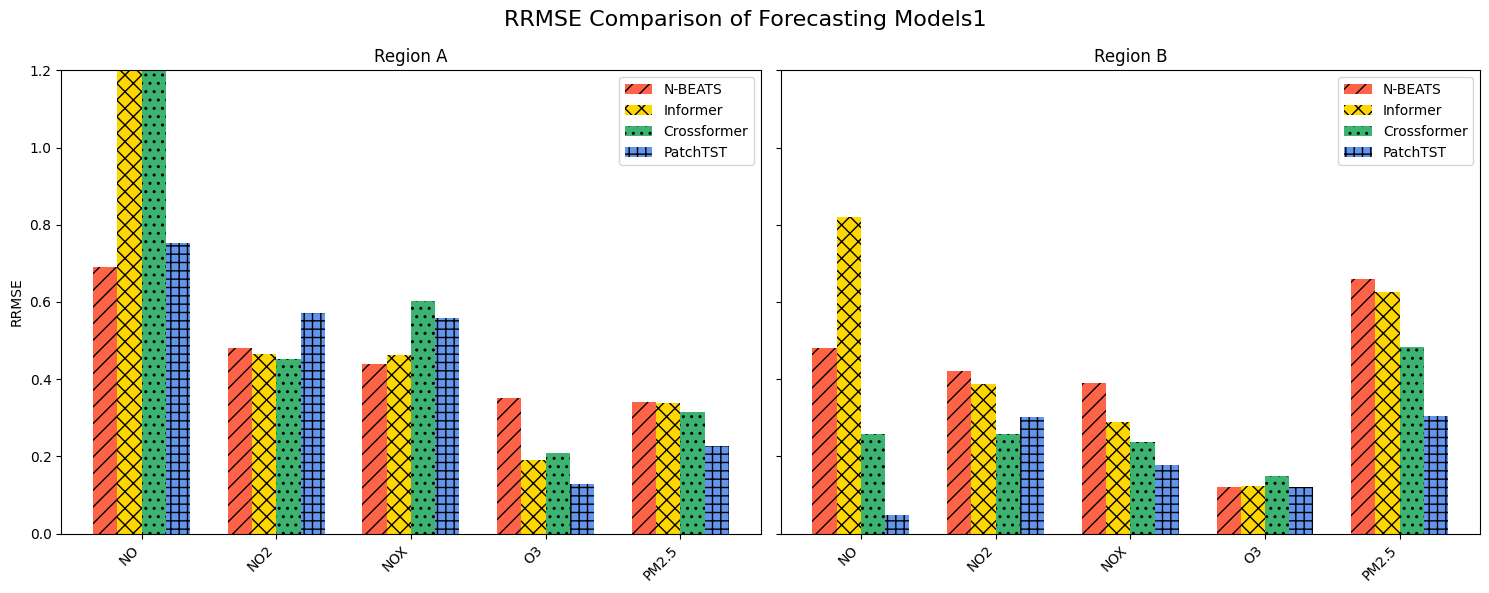

In [354]:
import numpy as np
import matplotlib.pyplot as plt

# === Get pollutant labels from index ===
pollutants = region_a.index.tolist()
x = np.arange(len(pollutants))
width = 0.18  # צמצום הרוחב כי יש 4 מודלים

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
clean_pollutants = [p.replace(" [ug/m^3]", "") for p in pollutants]

# === Region A ===
ax1.bar(x - 1.5*width, region_a["N-BEATS"], width=width, label='N-BEATS', color='tomato', hatch='//')
ax1.bar(x - 0.5*width, region_a["Informer"], width=width, label='Informer', color='gold', hatch='xx')
ax1.bar(x + 0.5*width, region_a["Crossformer"], width=width, label='Crossformer', color='mediumseagreen', hatch='..')
ax1.bar(x + 1.5*width, region_a["PatchTST"], width=width, label='PatchTST', color='cornflowerblue', hatch='++')
ax1.set_xticks(x)
ax1.set_xticklabels(clean_pollutants, rotation=45, ha="right")
ax1.set_ylim(0, 1.2)
ax1.set_title("Region A")
ax1.set_ylabel("RRMSE")
ax1.legend()

# === Region B ===
ax2.bar(x - 1.5*width, region_b["N-BEATS"], width=width, label='N-BEATS', color='tomato', hatch='//')
ax2.bar(x - 0.5*width, region_b["Informer"], width=width, label='Informer', color='gold', hatch='xx')
ax2.bar(x + 0.5*width, region_b["Crossformer"], width=width, label='Crossformer', color='mediumseagreen', hatch='..')
ax2.bar(x + 1.5*width, region_b["PatchTST"], width=width, label='PatchTST', color='cornflowerblue', hatch='++')
ax2.set_xticks(x)
ax2.set_xticklabels(clean_pollutants, rotation=45, ha="right")
ax2.set_ylim(0, 1.2)
ax2.set_title("Region B")
ax2.legend()

# === General settings ===
fig.suptitle("RRMSE Comparison of Forecasting Models1", fontsize=16)
plt.tight_layout()
fig.savefig("/Users/dorhalevy/Downloads/rrmse_per_pollutant_model.png", dpi=300, bbox_inches='tight')
plt.show()

# Running Time

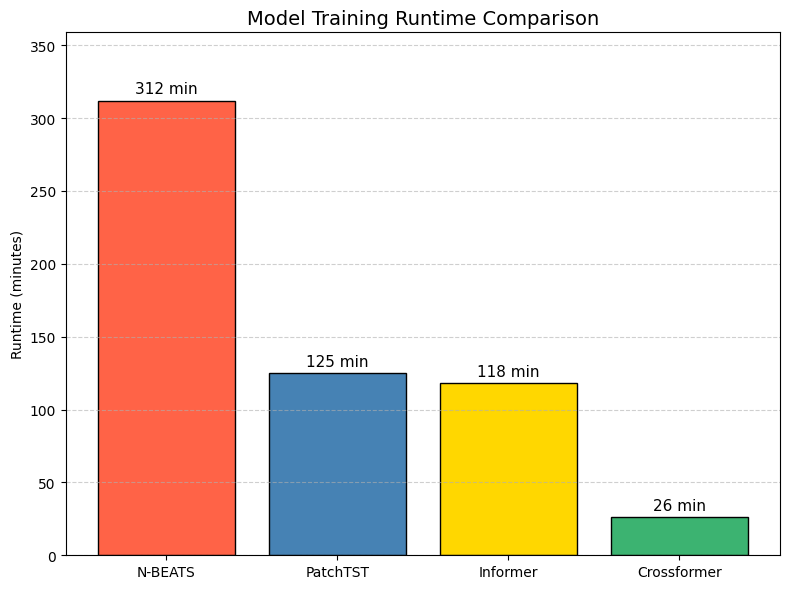

In [315]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Create DataFrame ===
runtime_data = {
    "Model": ["N-BEATS", "PatchTST", "Informer", "Crossformer"],
    "Runtime (min)": [312, 125, 118, 26]
}
runtime_df = pd.DataFrame(runtime_data)

# === Step 2: Plot ===
plt.figure(figsize=(8, 6))
bars = plt.bar(runtime_df["Model"], runtime_df["Runtime (min)"], color=["tomato", "steelblue", "gold", "mediumseagreen"], edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f"{int(height)} min", ha='center', fontsize=11)

plt.title("Model Training Runtime Comparison", fontsize=14)
plt.ylabel("Runtime (minutes)")
plt.ylim(0, max(runtime_df["Runtime (min)"]) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("/Users/dorhalevy/Downloads/training_time.png", dpi=300, bbox_inches='tight')
plt.show()

# Grid Search

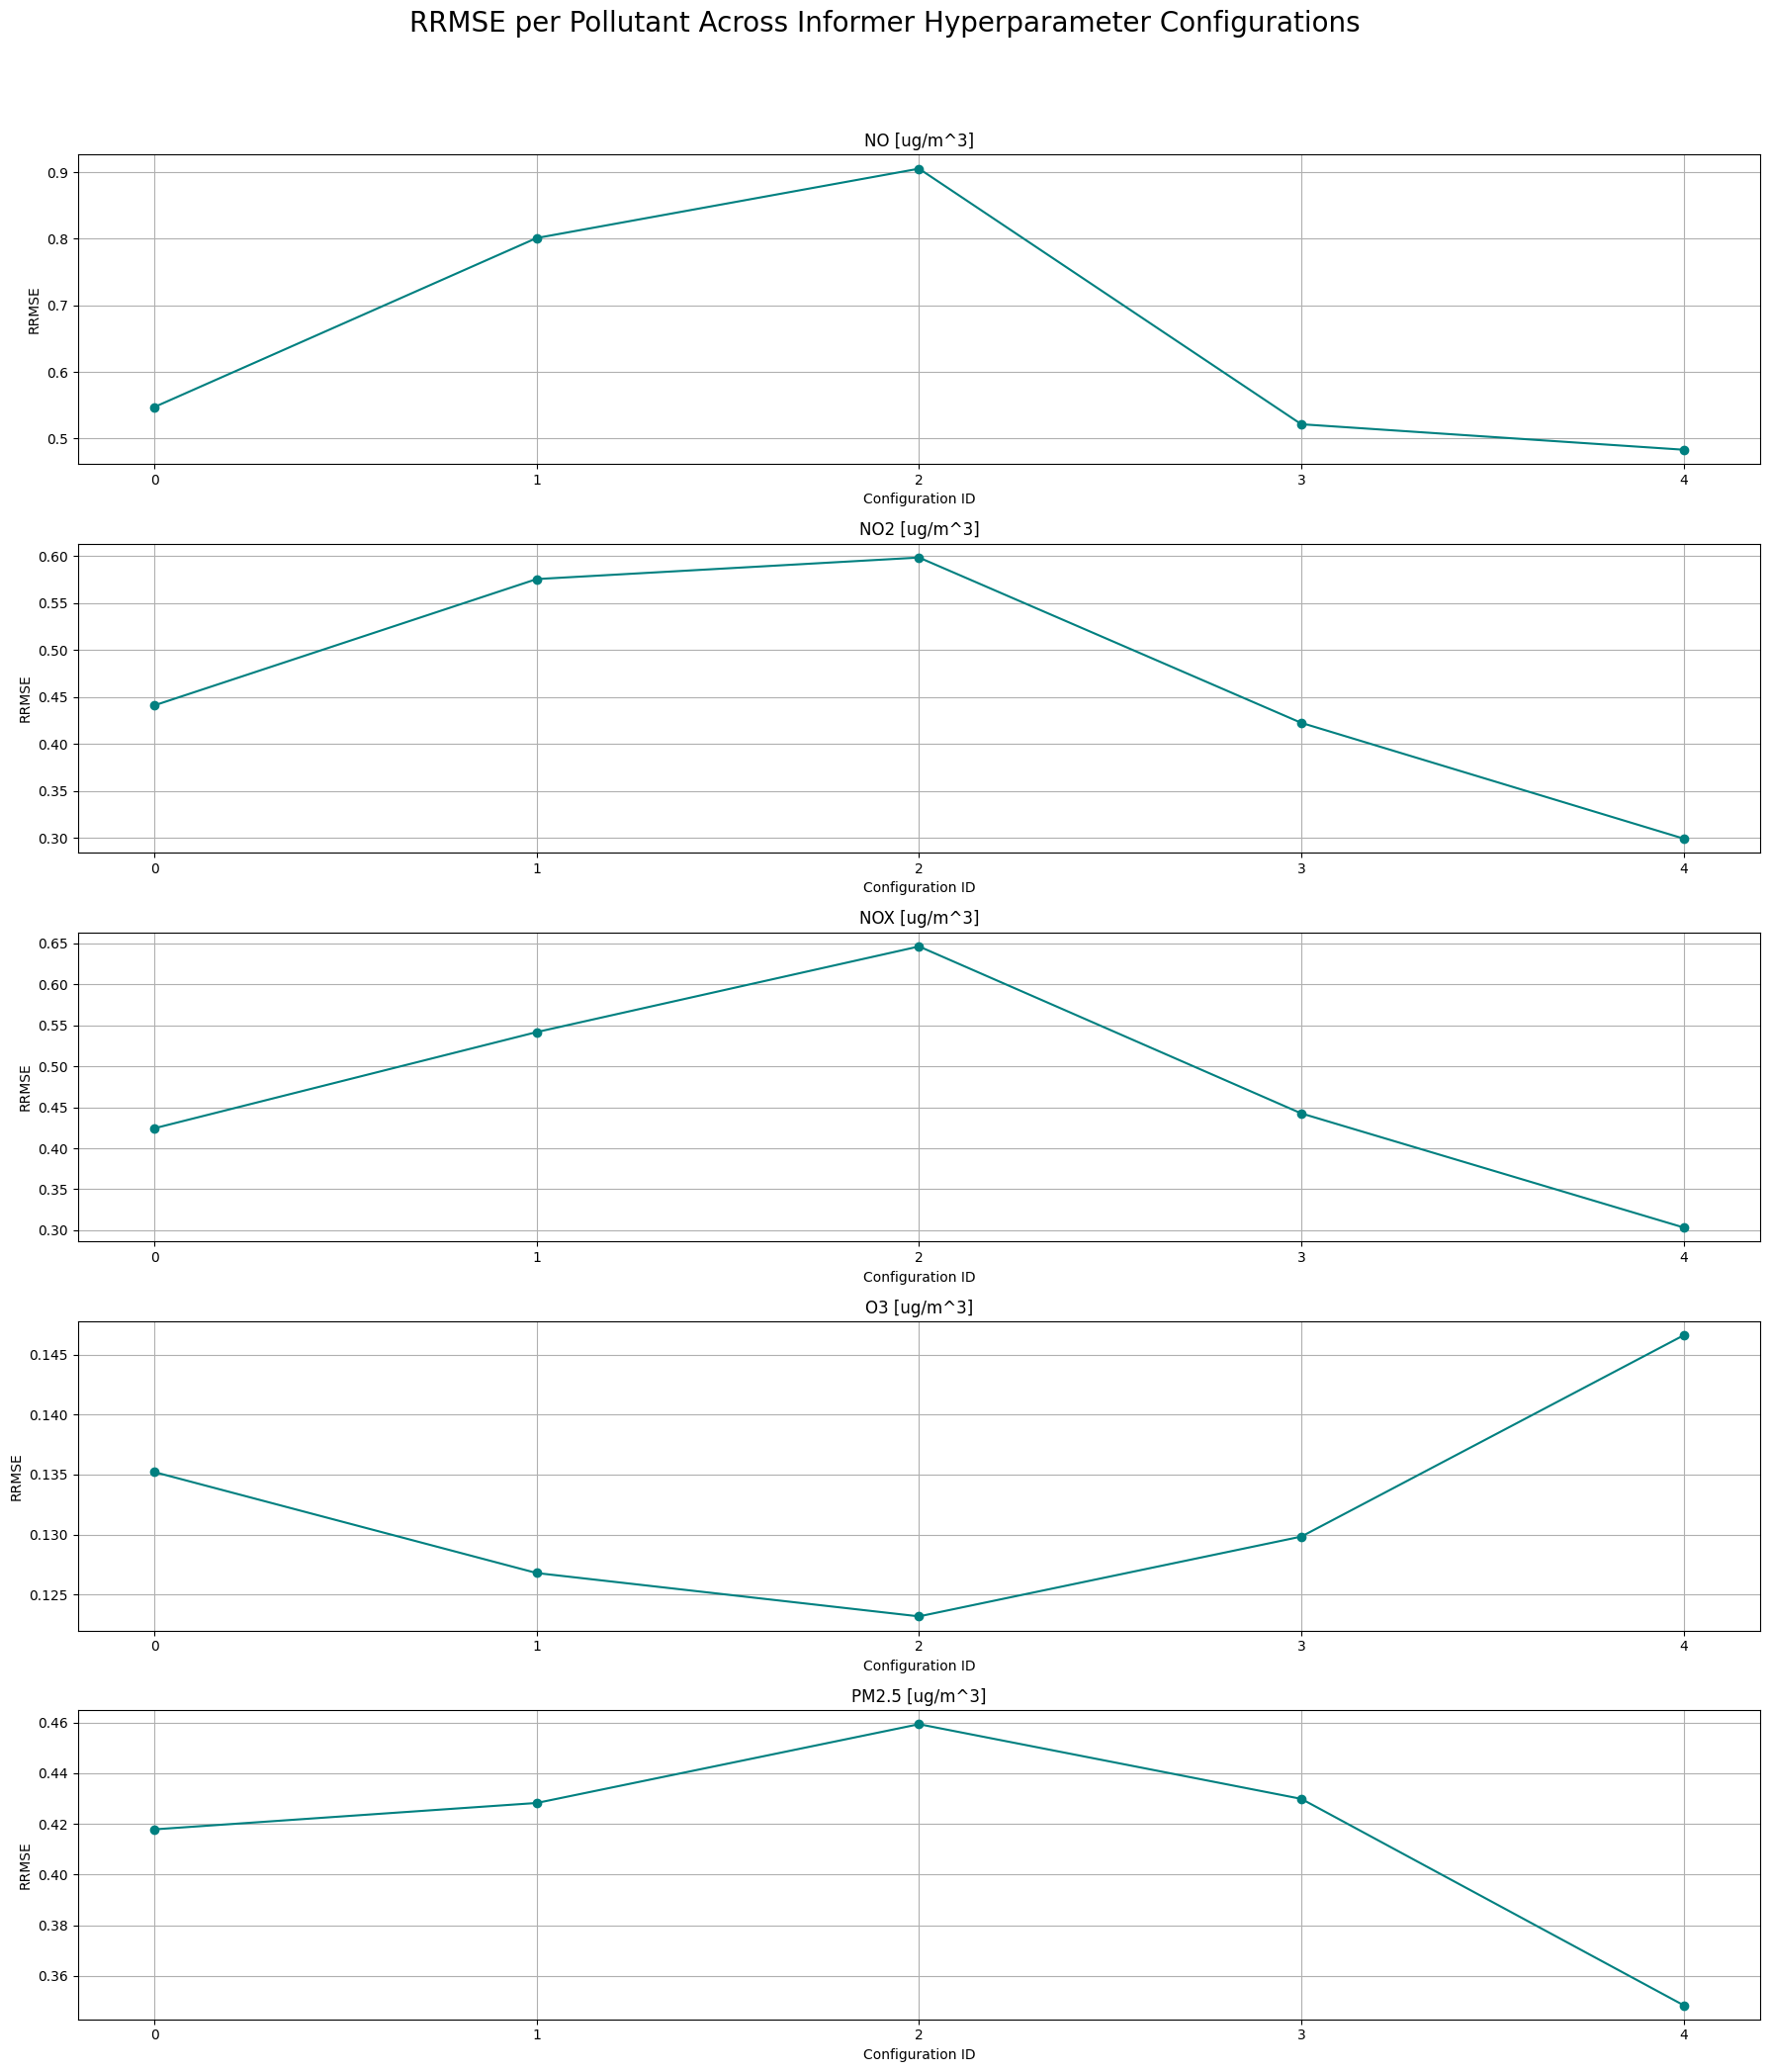

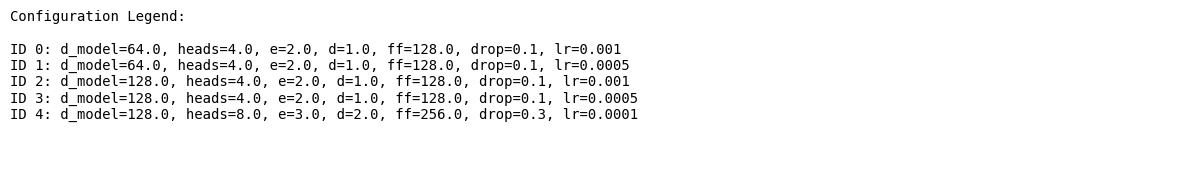

In [317]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load data ===
df = pd.read_csv("/Users/dorhalevy/grid_results/grid_search_results_ocast.csv")

# === Define pollutant columns ===
pollutant_cols = ['NO [ug/m^3]', 'NO2 [ug/m^3]', 'NOX [ug/m^3]', 'O3 [ug/m^3]', 'PM2.5 [ug/m^3]']

# === Define hyperparameters to show in legend (activation removed, lr added) ===
param_cols = ['d_model', 'n_heads', 'e_layers', 'd_layers', 'd_ff', 'dropout', 'lr']

# === Create readable string for each configuration ===
df['config_label'] = df[param_cols].apply(lambda row: 
    f"d_model={row['d_model']}, heads={row['n_heads']}, e={row['e_layers']}, d={row['d_layers']}, "
    f"ff={row['d_ff']}, drop={row['dropout']}, lr={row['lr']}", axis=1)

# === Use index as numeric identifier ===
df['config_id'] = df.index

# === Plot ===
fig, axes = plt.subplots(5, 1, figsize=(18, 22))

for i, pollutant in enumerate(pollutant_cols):
    ax = axes[i]
    ax.plot(df['config_id'], df[pollutant], marker='o', linestyle='-', color='teal')
    ax.set_title(pollutant)
    ax.set_ylabel("RRMSE")
    ax.set_xlabel("Configuration ID")
    ax.grid(True)
    ax.set_xticks(df['config_id'])


# === Global title ===
fig.suptitle("RRMSE per Pollutant Across Informer Hyperparameter Configurations", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# === Build Legend (outside plot) ===
legend_entries = [f"ID {i}: {cfg}" for i, cfg in zip(df['config_id'], df['config_label'])]
legend_text = "\n".join(legend_entries)

# === Display legend in new figure ===
fig_leg, ax_leg = plt.subplots(figsize=(12, len(df) * 0.4))
ax_leg.axis("off")
ax_leg.text(0, 1, "Configuration Legend:\n\n" + legend_text, fontsize=10, va='top', family='monospace')
plt.tight_layout()
plt.savefig("/Users/dorhalevy/Downloads/grissearch.png", dpi=300, bbox_inches='tight')
plt.show()

## Models Over 7 Days

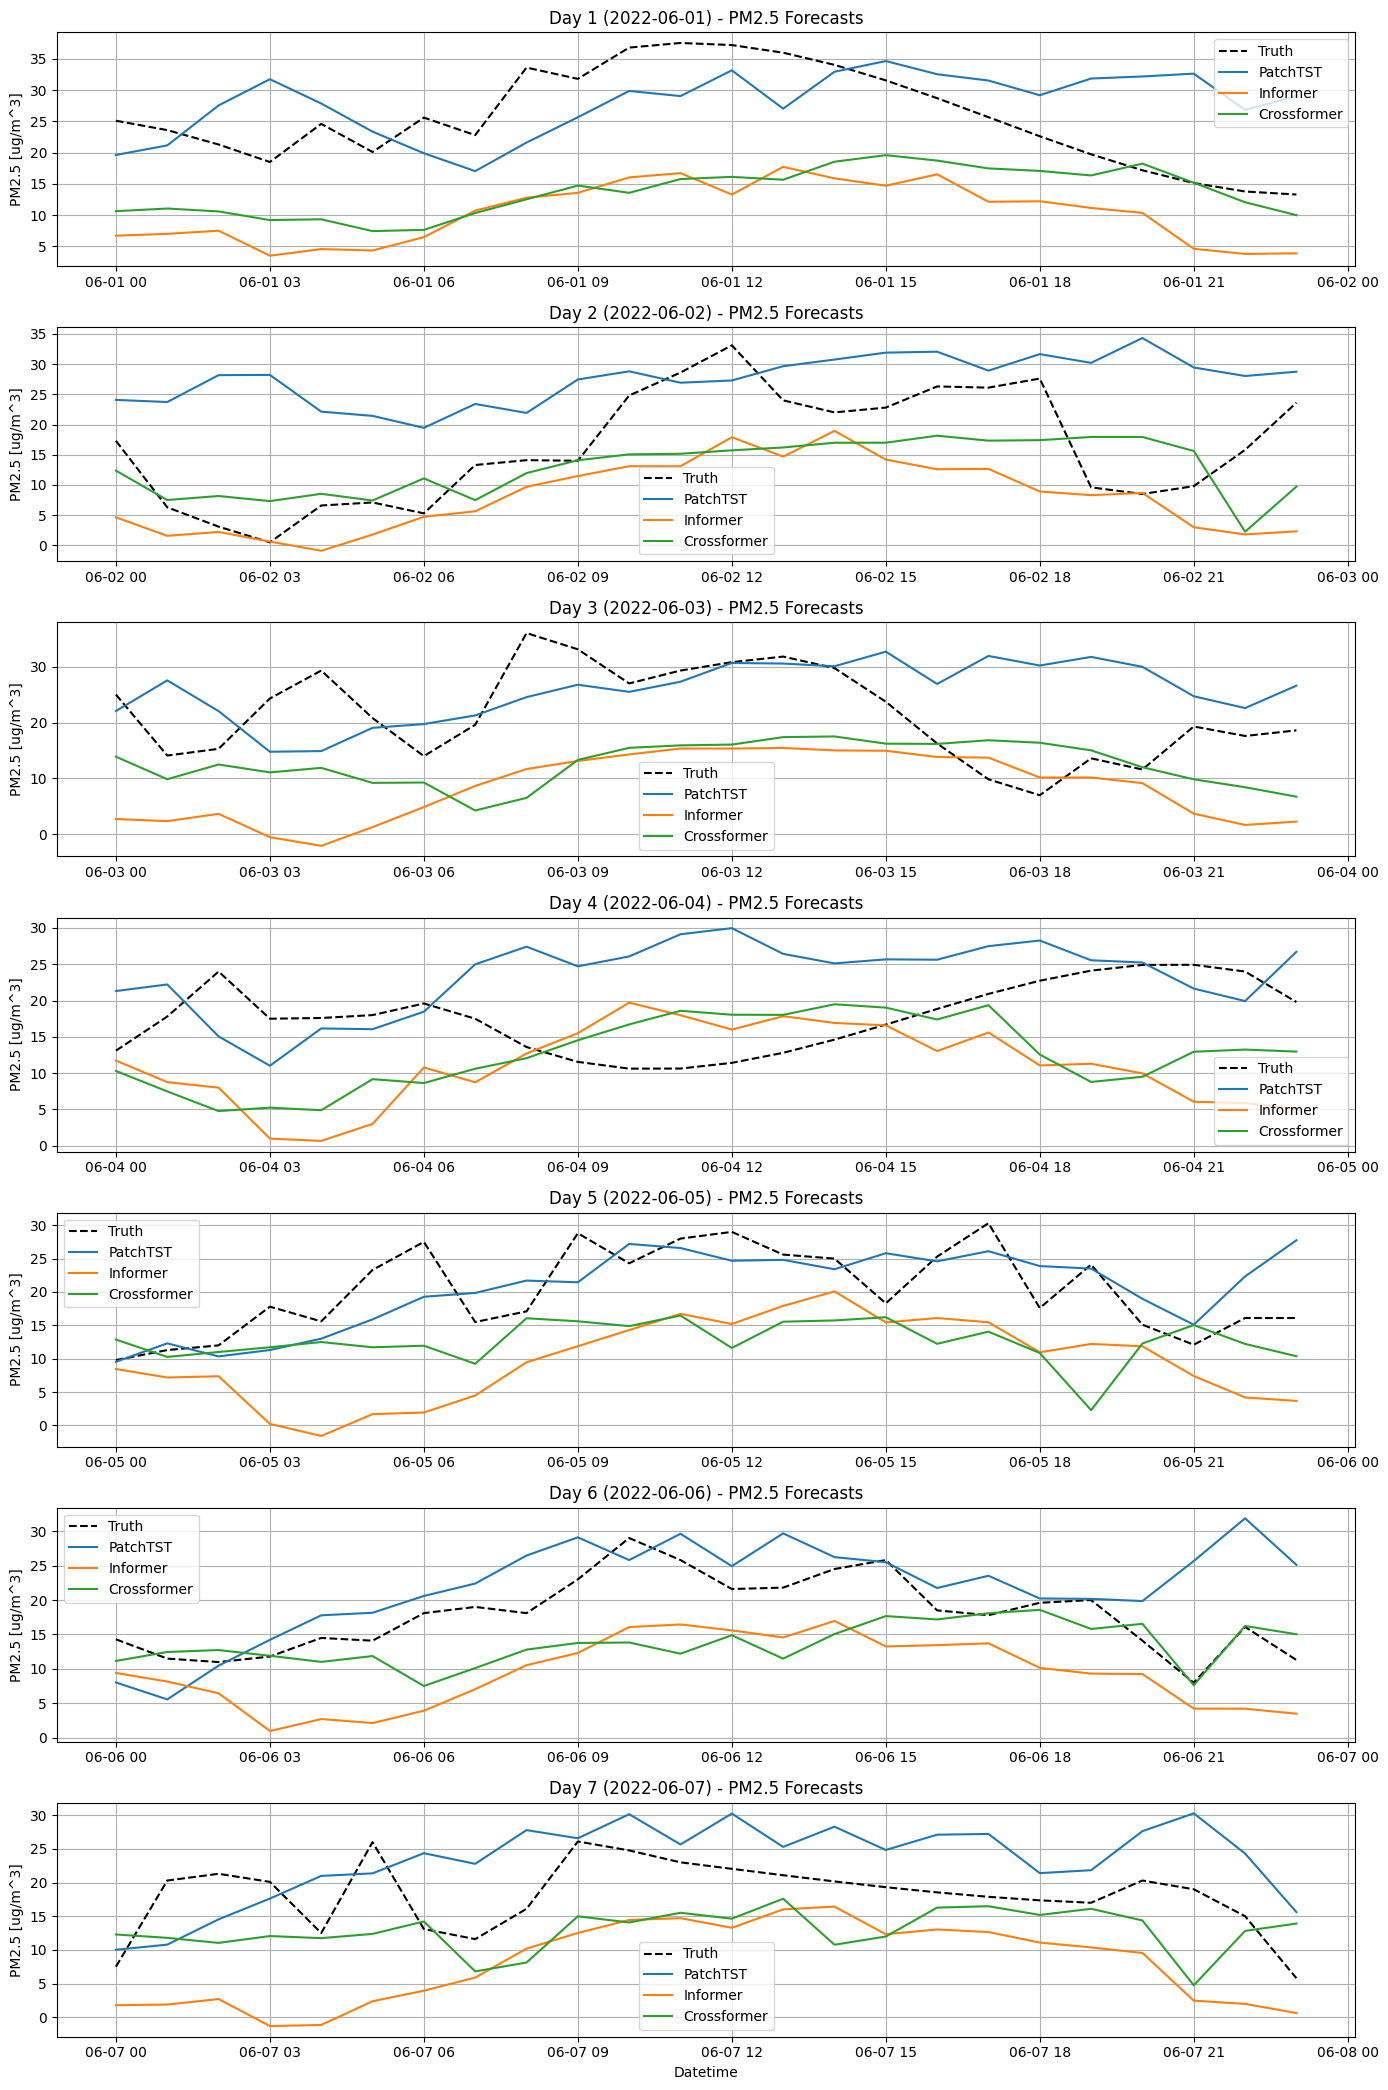

In [350]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# === CONFIG ===
BASE_DIRS = {
    "PatchTST": "/Users/dorhalevy/patchtst_single_target_results/PM2.5_ugm^3",
    "Informer": "/Users/dorhalevy/grid_results/run_0_south_prediction_truth",
    "Crossformer": "/Users/dorhalevy/crossformer_results"
}
TARGET_NAME = "PM2.5_[ugm^3]"
PRED_PREFIX = {
    "PatchTST": "day{day}.csv",
    "Informer": f"day{{day}}_{TARGET_NAME}_south.csv",
    "Crossformer": f"day{{day}}_{TARGET_NAME}_crossformer.csv"
}
NUM_DAYS = 7
START_DATE = datetime(2022, 5, 31)

# === Load and aggregate data ===
all_data = []

for day in range(1, NUM_DAYS + 1):
    day_data = {}
    for model in BASE_DIRS:
        file_path = os.path.join(BASE_DIRS[model], PRED_PREFIX[model].format(day=day))
        if not os.path.exists(file_path):
            print(f"❌ Missing file: {file_path}")
            continue
        df = pd.read_csv(file_path)

        # Create Datetime if needed
        if "Datetime" in df.columns:
            df["Datetime"] = pd.to_datetime(df["Datetime"])
        else:
            start_datetime = START_DATE + timedelta(days=day)
            df["Datetime"] = [start_datetime + timedelta(hours=i) for i in range(len(df))]

        # Use Informer ground truth
        if model == "Informer":
            day_data["Truth"] = df["truth"]
            day_data["Datetime"] = df["Datetime"]

        # Store model prediction
        day_data[model] = df["prediction"]
    
    if "Datetime" in day_data:
        all_data.append(pd.DataFrame(day_data))

# === Plot ===
fig, axes = plt.subplots(nrows=NUM_DAYS, ncols=1, figsize=(14, 3 * NUM_DAYS), sharex=False)

for i, df_day in enumerate(all_data):
    ax = axes[i]
    ax.plot(df_day["Datetime"], df_day["Truth"], label="Truth", linestyle="--", color="black")
    for model in ["PatchTST", "Informer", "Crossformer"]:
        if model in df_day:
            ax.plot(df_day["Datetime"], df_day[model], label=model)
    ax.set_title(f"Day {i+1} ({df_day['Datetime'].iloc[0].date()}) - PM2.5 Forecasts")
    ax.set_ylabel("PM2.5 [ug/m^3]")
    ax.grid(True)
    ax.legend()

plt.xlabel("Datetime")
plt.tight_layout()
plt.savefig("/Users/dorhalevy/Downloads/days.png", dpi=300, bbox_inches='tight')
plt.show()

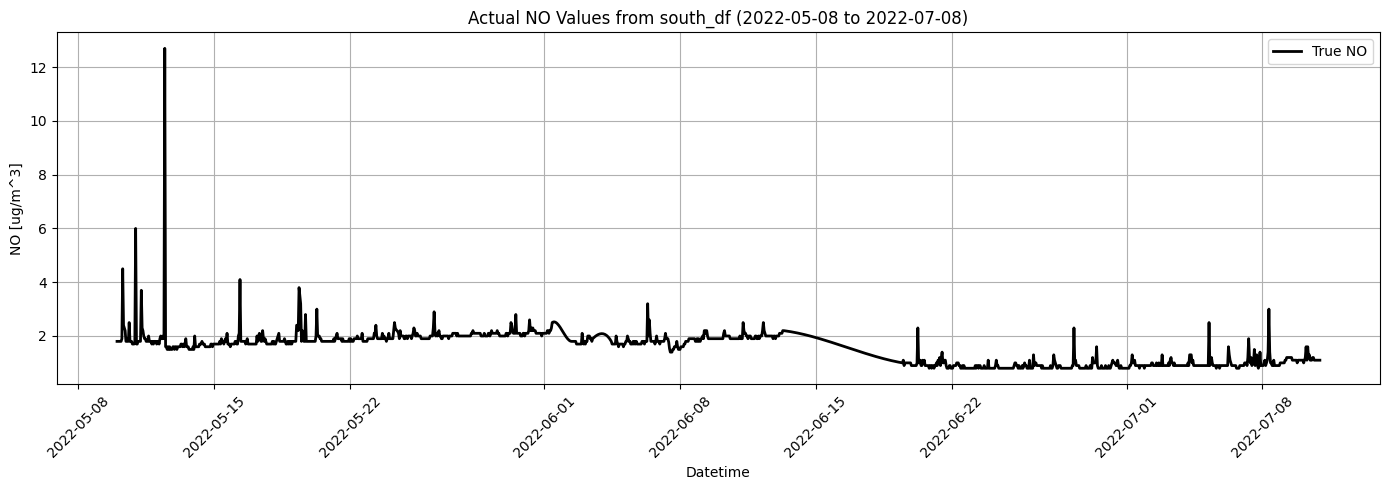

In [335]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load data ===
df = pd.read_excel("south_df.xlsx")
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime").sort_index()
df = df.resample("H").asfreq().interpolate().dropna()

# === Slice to test period: 1.6.2022–7.6.2022 ===
start_date = "2022-05-10"
end_date = "2022-07-10" 
df_test = df.loc[start_date:end_date]

# === Plot ===
plt.figure(figsize=(14, 5))
plt.plot(df_test.index, df_test["NO [ug/m^3]"], label="True NO", color="black", linewidth=2)
plt.title("Actual NO Values from south_df (2022-05-08 to 2022-07-08)")
plt.xlabel("Datetime")
plt.ylabel("NO [ug/m^3]")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.savefig("/Users/dorhalevy/Downloads/no.png", dpi=300, bbox_inches='tight')
plt.show()

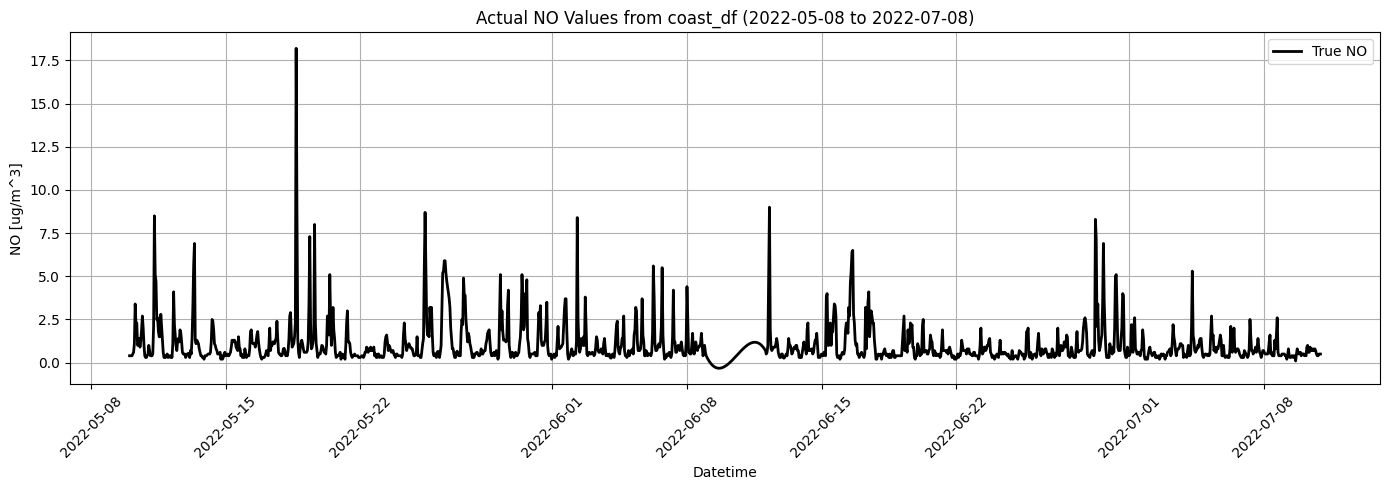

In [356]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load data ===
df = pd.read_excel("coast_df.xlsx")
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime").sort_index()
df = df.resample("H").asfreq().interpolate().dropna()

# === Slice to test period: 1.6.2022–7.6.2022 ===
start_date = "2022-05-10"
end_date = "2022-07-10"  
df_test = df.loc[start_date:end_date]

# === Plot ===
plt.figure(figsize=(14, 5))
plt.plot(df_test.index, df_test["NO [ug/m^3]"], label="True NO", color="black", linewidth=2)
plt.title("Actual NO Values from coast_df (2022-05-08 to 2022-07-08)")
plt.xlabel("Datetime")
plt.ylabel("NO [ug/m^3]")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.savefig("/Users/dorhalevy/Downloads/no_coast.png", dpi=300, bbox_inches='tight')
plt.show()

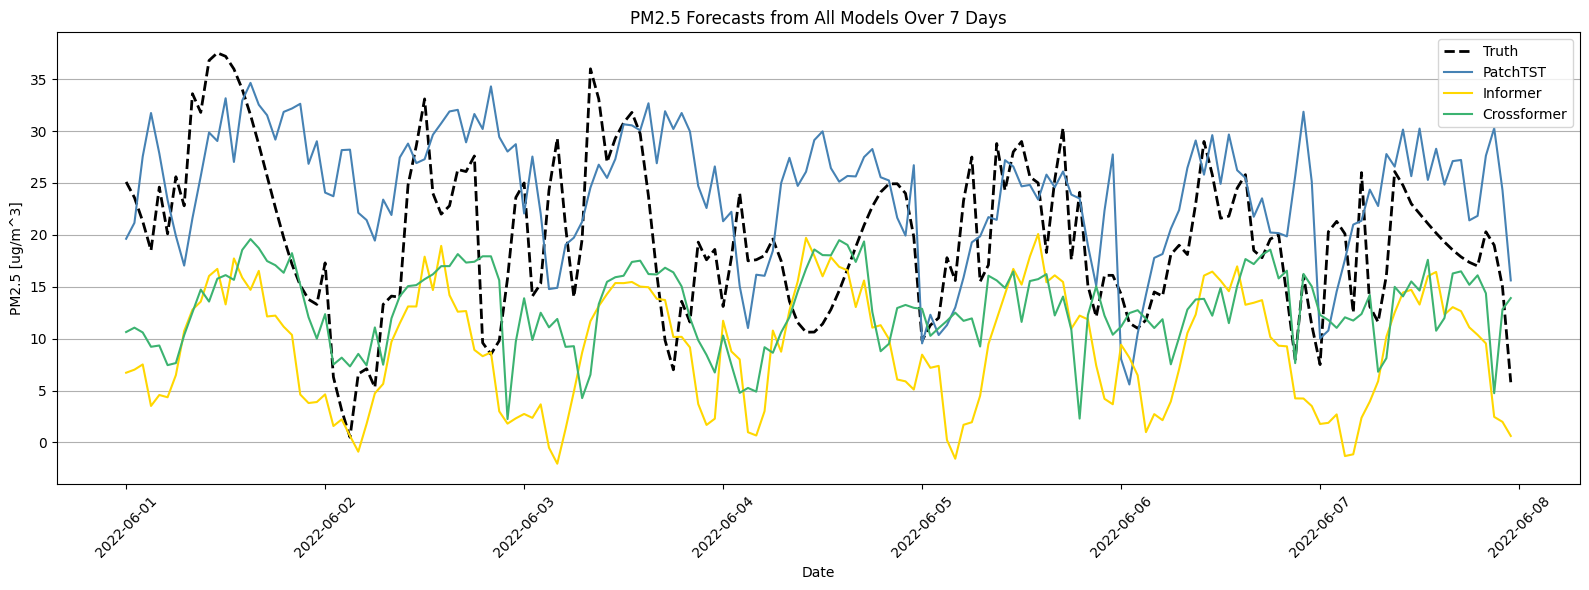

In [348]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === CONFIG ===
BASE_DIRS = {
    "PatchTST": "/Users/dorhalevy/patchtst_single_target_results/PM2.5_ugm^3",
    "Informer": "/Users/dorhalevy/grid_results/run_0_south_prediction_truth",
    "Crossformer": "/Users/dorhalevy/crossformer_results"
}
TARGET_NAME = "PM2.5_[ugm^3]"
NUM_DAYS = 7

PRED_PREFIX = {
    "PatchTST": "day{day}.csv",
    "Informer": f"day{{day}}_{TARGET_NAME}_south.csv",
    "Crossformer": f"day{{day}}_{TARGET_NAME}_crossformer.csv"
}

MODEL_COLORS = {
    "PatchTST": "#4682B4",
    "Informer": "#FFD700",
    "Crossformer": "#3CB371",
    "Truth": "black"
}

# === Load and Combine Data ===
full_df = pd.DataFrame()

for day in range(1, NUM_DAYS + 1):
    day_data = {"Datetime": None, "Truth": None}
    day_dfs = {}

    # Load Informer (for datetime + truth)
    informer_path = os.path.join(BASE_DIRS["Informer"], PRED_PREFIX["Informer"].format(day=day))
    if not os.path.exists(informer_path):
        print(f"❌ Missing Informer file: {informer_path}")
        continue

    informer_df = pd.read_csv(informer_path)
    informer_df["Datetime"] = pd.to_datetime(informer_df["datetime"])
    day_data["Datetime"] = informer_df["Datetime"]
    day_data["Truth"] = informer_df["truth"]
    day_dfs["Informer"] = informer_df["prediction"]

    for model in ["PatchTST", "Crossformer"]:
        file_path = os.path.join(BASE_DIRS[model], PRED_PREFIX[model].format(day=day))
        if not os.path.exists(file_path):
            print(f"❌ Missing file: {file_path}")
            continue
        df = pd.read_csv(file_path)
        day_dfs[model] = df["prediction"]

    combined = pd.DataFrame({
        "Datetime": day_data["Datetime"],
        "Truth": day_data["Truth"],
        "PatchTST": day_dfs.get("PatchTST", pd.Series([None]*24)),
        "Informer": day_dfs.get("Informer", pd.Series([None]*24)),
        "Crossformer": day_dfs.get("Crossformer", pd.Series([None]*24)),
    })
    full_df = pd.concat([full_df, combined], ignore_index=True)

# === Plot Clean Version ===
plt.figure(figsize=(16, 6))
plt.plot(full_df["Datetime"], full_df["Truth"], label="Truth", color=MODEL_COLORS["Truth"], linestyle="--", linewidth=2)
for model in ["PatchTST", "Informer", "Crossformer"]:
    plt.plot(full_df["Datetime"], full_df[model], label=model, color=MODEL_COLORS[model])

# Format X-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)

plt.title("PM2.5 Forecasts from All Models Over 7 Days")
plt.xlabel("Date")
plt.ylabel("PM2.5 [ug/m^3]")
plt.legend()
plt.grid(True, axis='y') 
plt.tight_layout()
plt.savefig("/Users/dorhalevy/Downloads/alldaystogether.png", dpi=300, bbox_inches='tight')
plt.show()